# 📊 Indicadores de Saúde do Nordeste - MedFast Analytics

Este notebook apresenta visualizações detalhadas das principais taxas e indicadores de saúde da região Nordeste, com foco em **40% capitais** e **60% interior** (raio 100km).

## 🎯 Objetivos:
- Criar gráficos individuais para cada taxa de saúde identificada
- Preparar estrutura para leitura de arquivos e conexões REST
- Facilitar integração futura com data lake
- Disponibilizar dados para aplicações Python/Jupyter

## 📈 Indicadores Cobertos:
1. **Taxa de Ocupação Hospitalar** por região
2. **Penetração de Planos de Saúde** (capitais vs interior)
3. **Conectividade e Digitalização** por município
4. **Resolutividade Local** por nível de complexidade
5. **Tempo de Referência** entre níveis assistenciais
6. **Distribuição de Especialidades** por região
7. **Indicadores Demográficos** e perfil populacional
8. **Performance de Sistemas** por contexto regional

In [2]:
# ===============================
# 1. IMPORT REQUIRED LIBRARIES
# ===============================

# Core data manipulation and analysis
import pandas as pd
import numpy as np
import json
import sqlite3
from datetime import datetime, timedelta

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Geospatial and mapping libraries
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    import geopandas as gpd
    from shapely.geometry import Point, Polygon
    import contextily as ctx
    GEOSPATIAL_AVAILABLE = True
    print("✅ Bibliotecas geoespaciais disponíveis (Cartopy, GeoPandas)")
except ImportError as e:
    print(f"⚠️ Algumas bibliotecas geoespaciais não estão disponíveis: {e}")
    print("💡 Para instalar: pip install cartopy geopandas shapely contextily")
    GEOSPATIAL_AVAILABLE = False

# REST API and HTTP requests
import requests
from requests.auth import HTTPBasicAuth
import urllib3
from urllib.parse import urljoin

# Data lake and cloud storage
import pyarrow as pa
import pyarrow.parquet as pq
try:
    import boto3
    AWS_AVAILABLE = True
except ImportError:
    print("⚠️ boto3 não disponível - recursos AWS limitados")
    AWS_AVAILABLE = False

try:
    from azure.storage.blob import BlobServiceClient
    AZURE_AVAILABLE = True
except ImportError:
    print("⚠️ azure-storage-blob não disponível - recursos Azure limitados")
    AZURE_AVAILABLE = False

# Statistical analysis
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Configuration and utilities
import os
import sys
import warnings
from pathlib import Path
import logging
from typing import Dict, List, Optional, Union
import subprocess
import pkg_resources

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
urllib3.disable_warnings()

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# VIRTUAL ENVIRONMENT VERIFICATION
def verificar_ambiente_virtual():
    """
    Verifica ambiente virtual ativo, versões das dependências e compatibilidade
    """
    
    print("\n🔍 VERIFICAÇÃO DO AMBIENTE VIRTUAL")
    print("=" * 50)
    
    # 1. Verificar se está em ambiente virtual
    in_venv = sys.prefix != sys.base_prefix
    venv_path = sys.prefix if in_venv else "Sistema global"
    
    print(f"🐍 Python Version: {sys.version}")
    print(f"📁 Python Path: {sys.executable}")
    print(f"🏠 Virtual Environment: {'✅ Ativo' if in_venv else '❌ Não detectado'}")
    print(f"📂 Environment Path: {venv_path}")
    
    # 2. Verificar dependências críticas
    dependencias_criticas = {
        'pandas': '>=1.3.0',
        'numpy': '>=1.20.0', 
        'plotly': '>=5.0.0',
        'matplotlib': '>=3.3.0',
        'requests': '>=2.25.0',
        'pyarrow': '>=5.0.0'
    }
    
    dependencias_geoespaciais = {
        'cartopy': '>=0.20.0',
        'geopandas': '>=0.10.0',
        'shapely': '>=1.8.0',
        'contextily': '>=1.2.0'
    }
    
    print(f"\n📦 DEPENDÊNCIAS CRÍTICAS:")
    dependencias_ok = 0
    total_dependencias = len(dependencias_criticas)
    
    for package, min_version in dependencias_criticas.items():
        try:
            version = pkg_resources.get_distribution(package).version
            print(f"   ✅ {package}: {version}")
            dependencias_ok += 1
        except pkg_resources.DistributionNotFound:
            print(f"   ❌ {package}: NÃO INSTALADO (requerido: {min_version})")
        except Exception as e:
            print(f"   ⚠️ {package}: Erro na verificação - {e}")
    
    print(f"\n🗺️ DEPENDÊNCIAS GEOESPACIAIS:")
    geo_ok = 0
    total_geo = len(dependencias_geoespaciais)
    
    for package, min_version in dependencias_geoespaciais.items():
        try:
            version = pkg_resources.get_distribution(package).version
            print(f"   ✅ {package}: {version}")
            geo_ok += 1
        except pkg_resources.DistributionNotFound:
            print(f"   ❌ {package}: NÃO INSTALADO (requerido: {min_version})")
        except Exception as e:
            print(f"   ⚠️ {package}: Erro na verificação - {e}")
    
    # 3. Verificar cloud dependencies
    print(f"\n☁️ DEPENDÊNCIAS CLOUD:")
    if AWS_AVAILABLE:
        try:
            version = pkg_resources.get_distribution('boto3').version
            print(f"   ✅ boto3 (AWS): {version}")
        except:
            print(f"   ⚠️ boto3: Versão não detectada")
    else:
        print(f"   ❌ boto3: NÃO DISPONÍVEL")
    
    if AZURE_AVAILABLE:
        try:
            version = pkg_resources.get_distribution('azure-storage-blob').version
            print(f"   ✅ azure-storage-blob: {version}")
        except:
            print(f"   ⚠️ azure-storage-blob: Versão não detectada")
    else:
        print(f"   ❌ azure-storage-blob: NÃO DISPONÍVEL")
    
    # 4. Comandos de instalação se necessário
    print(f"\n💡 COMANDOS DE INSTALAÇÃO (se necessário):")
    
    if dependencias_ok < total_dependencias:
        print(f"   📦 Básicas: pip install pandas numpy plotly matplotlib requests pyarrow")
    
    if geo_ok < total_geo:
        print(f"   🗺️ Geoespaciais: pip install cartopy geopandas shapely contextily")
        print(f"      🔗 Alternativa conda: conda install -c conda-forge cartopy geopandas")
    
    if not AWS_AVAILABLE:
        print(f"   ☁️ AWS: pip install boto3")
    
    if not AZURE_AVAILABLE:
        print(f"   ☁️ Azure: pip install azure-storage-blob")
    
    # 5. Resumo da compatibilidade
    compatibilidade_geral = (dependencias_ok / total_dependencias) * 100
    compatibilidade_geo = (geo_ok / total_geo) * 100 if total_geo > 0 else 0
    
    print(f"\n📊 RESUMO DE COMPATIBILIDADE:")
    print(f"   🎯 Funcionalidades Básicas: {compatibilidade_geral:.0f}% ({dependencias_ok}/{total_dependencias})")
    print(f"   🗺️ Recursos Geoespaciais: {compatibilidade_geo:.0f}% ({geo_ok}/{total_geo})")
    print(f"   🏠 Ambiente Virtual: {'✅' if in_venv else '⚠️ Recomendado usar venv'}")
    
    if compatibilidade_geral >= 100 and compatibilidade_geo >= 100:
        print(f"   🚀 Status: TOTALMENTE COMPATÍVEL")
    elif compatibilidade_geral >= 100:
        print(f"   ✅ Status: COMPATÍVEL (mapas limitados)")
    else:
        print(f"   ⚠️ Status: INSTALAR DEPENDÊNCIAS FALTANTES")
    
    return {
        'virtual_env_active': in_venv,
        'basic_compatibility': compatibilidade_geral,
        'geospatial_compatibility': compatibilidade_geo,
        'aws_available': AWS_AVAILABLE,
        'azure_available': AZURE_AVAILABLE,
        'cartopy_available': GEOSPATIAL_AVAILABLE
    }

# Executar verificação
ambiente_status = verificar_ambiente_virtual()

print("✅ Bibliotecas importadas com sucesso!")
print(f"📊 Pandas version: {pd.__version__}")
try:
    import plotly
    print(f"📈 Plotly version: {plotly.__version__}")
except:
    print(f"📈 Plotly version: Disponível")
print(f"🔍 Numpy version: {np.__version__}")
print(f"🗺️ Cartopy disponível: {'✅' if GEOSPATIAL_AVAILABLE else '❌'}")

✅ Bibliotecas geoespaciais disponíveis (Cartopy, GeoPandas)

🔍 VERIFICAÇÃO DO AMBIENTE VIRTUAL
🐍 Python Version: 3.13.3 (tags/v3.13.3:6280bb5, Apr  8 2025, 14:47:33) [MSC v.1943 64 bit (AMD64)]
📁 Python Path: c:\Users\italo\AppData\Local\Programs\Python\Python313\python.exe
🏠 Virtual Environment: ❌ Não detectado
📂 Environment Path: Sistema global

📦 DEPENDÊNCIAS CRÍTICAS:
   ✅ pandas: 2.3.2
   ✅ numpy: 2.3.2
   ✅ plotly: 6.3.1
   ✅ matplotlib: 3.10.6
   ✅ requests: 2.32.5
   ✅ pyarrow: 21.0.0

🗺️ DEPENDÊNCIAS GEOESPACIAIS:
   ✅ cartopy: 0.25.0
   ✅ geopandas: 1.1.1
   ✅ shapely: 2.1.2
   ✅ contextily: 1.6.2

☁️ DEPENDÊNCIAS CLOUD:
   ✅ boto3 (AWS): 1.40.58
   ✅ azure-storage-blob: 12.27.0

💡 COMANDOS DE INSTALAÇÃO (se necessário):

📊 RESUMO DE COMPATIBILIDADE:
   🎯 Funcionalidades Básicas: 100% (6/6)
   🗺️ Recursos Geoespaciais: 100% (4/4)
   🏠 Ambiente Virtual: ⚠️ Recomendado usar venv
   🚀 Status: TOTALMENTE COMPATÍVEL
✅ Bibliotecas importadas com sucesso!
📊 Pandas version: 2.3.2
📈 P

In [3]:
# ===============================
# 2. CONFIGURE DATA CONNECTIONS
# ===============================

class DataSourceConfig:
    """Configuração centralizada para fontes de dados de saúde"""
    
    def __init__(self):
        # Configurações de arquivos locais
        self.BASE_PATH = Path("c:/workspace/aplicativo")
        self.DATA_PATH = self.BASE_PATH / "data"
        self.DOCS_PATH = self.BASE_PATH / "docs"
        self.CONFIG_PATH = self.BASE_PATH / "config"
        
        # Endpoints da API MedFast
        self.API_BASE_URL = "http://localhost:3002/api"
        self.API_ENDPOINTS = {
            'patients': f"{self.API_BASE_URL}/patients",
            'doctors': f"{self.API_BASE_URL}/doctors", 
            'organizations': f"{self.API_BASE_URL}/organizations",
            'statistics': f"{self.API_BASE_URL}/statistics",
            'regional': f"{self.API_BASE_URL}/regional"
        }
        
        # Configurações de APIs externas (SUS, ANS, etc.)
        self.EXTERNAL_APIS = {
            'datasus': "https://apidadosabertos.saude.gov.br/cnes",
            'ans': "https://www.ans.gov.br/anstabnet",
            'ibge': "https://servicodados.ibge.gov.br/api/v1"
        }
        
        # Configurações para futuro data lake
        self.DATALAKE_CONFIG = {
            'aws_bucket': 'medfast-datalake-nordeste',
            'azure_container': 'medfast-analytics',
            'partition_columns': ['estado', 'tipo_municipio', 'data_referencia']
        }
        
        # Headers para requisições HTTP
        self.DEFAULT_HEADERS = {
            'User-Agent': 'MedFast-Analytics/1.0',
            'Content-Type': 'application/json',
            'Accept': 'application/json'
        }
        
        # Criar diretórios se não existirem
        self.DATA_PATH.mkdir(exist_ok=True)
        
    def get_file_path(self, filename: str) -> Path:
        """Retorna caminho completo para arquivo de dados"""
        return self.DATA_PATH / filename
    
    def get_api_headers(self, token: str = None) -> Dict:
        """Retorna headers para chamadas API"""
        headers = self.DEFAULT_HEADERS.copy()
        if token:
            headers['Authorization'] = f'Bearer {token}'
        return headers

# Instanciar configuração global
config = DataSourceConfig()

# Dados simulados baseados na análise regional
DADOS_NORDESTE_SIMULADOS = {
    'capitais': [
        {'cidade': 'Salvador', 'estado': 'BA', 'populacao': 2900000, 'ocupacao_hospitalar': 0.87, 'planos_saude': 0.35, 'conectividade': 95, 'digitalizacao': 0.80, 'latitude': -12.9714, 'longitude': -38.5014},
        {'cidade': 'Fortaleza', 'estado': 'CE', 'populacao': 2700000, 'ocupacao_hospitalar': 0.83, 'planos_saude': 0.32, 'conectividade': 98, 'digitalizacao': 0.85, 'latitude': -3.7319, 'longitude': -38.5267},
        {'cidade': 'Recife', 'estado': 'PE', 'populacao': 1700000, 'ocupacao_hospitalar': 0.89, 'planos_saude': 0.38, 'conectividade': 92, 'digitalizacao': 0.75, 'latitude': -8.0476, 'longitude': -34.8770},
        {'cidade': 'São Luís', 'estado': 'MA', 'populacao': 1100000, 'ocupacao_hospitalar': 0.82, 'planos_saude': 0.28, 'conectividade': 88, 'digitalizacao': 0.70, 'latitude': -2.5387, 'longitude': -44.2825},
        {'cidade': 'Teresina', 'estado': 'PI', 'populacao': 870000, 'ocupacao_hospitalar': 0.79, 'planos_saude': 0.25, 'conectividade': 85, 'digitalizacao': 0.68, 'latitude': -5.0892, 'longitude': -42.8019},
        {'cidade': 'Natal', 'estado': 'RN', 'populacao': 890000, 'ocupacao_hospitalar': 0.81, 'planos_saude': 0.30, 'conectividade': 90, 'digitalizacao': 0.72, 'latitude': -5.7945, 'longitude': -35.2110},
        {'cidade': 'João Pessoa', 'estado': 'PB', 'populacao': 820000, 'ocupacao_hospitalar': 0.78, 'planos_saude': 0.27, 'conectividade': 87, 'digitalizacao': 0.69, 'latitude': -7.1195, 'longitude': -34.8450},
        {'cidade': 'Maceió', 'estado': 'AL', 'populacao': 1000000, 'ocupacao_hospitalar': 0.84, 'planos_saude': 0.29, 'conectividade': 89, 'digitalizacao': 0.71, 'latitude': -9.6658, 'longitude': -35.7353},
        {'cidade': 'Aracaju', 'estado': 'SE', 'populacao': 664000, 'ocupacao_hospitalar': 0.76, 'planos_saude': 0.31, 'conectividade': 91, 'digitalizacao': 0.73, 'latitude': -10.9472, 'longitude': -37.0731}
    ],
    'interior_grande': [
        {'cidade': 'Feira de Santana', 'estado': 'BA', 'populacao': 619609, 'ocupacao_hospitalar': 0.75, 'planos_saude': 0.18, 'conectividade': 70, 'digitalizacao': 0.60, 'distancia_capital': 108, 'resolutividade': 0.75, 'latitude': -12.2664, 'longitude': -38.9663},
        {'cidade': 'Petrolina', 'estado': 'PE', 'populacao': 354317, 'ocupacao_hospitalar': 0.72, 'planos_saude': 0.15, 'conectividade': 65, 'digitalizacao': 0.55, 'distancia_capital': 720, 'resolutividade': 0.70, 'latitude': -9.3891, 'longitude': -40.5034},
        {'cidade': 'Caruaru', 'estado': 'PE', 'populacao': 361118, 'ocupacao_hospitalar': 0.77, 'planos_saude': 0.20, 'conectividade': 68, 'digitalizacao': 0.58, 'distancia_capital': 134, 'resolutividade': 0.70, 'latitude': -8.2836, 'longitude': -35.9758},
        {'cidade': 'Mossoró', 'estado': 'RN', 'populacao': 295619, 'ocupacao_hospitalar': 0.73, 'planos_saude': 0.16, 'conectividade': 63, 'digitalizacao': 0.53, 'distancia_capital': 277, 'resolutividade': 0.68, 'latitude': -5.1880, 'longitude': -37.3441}
    ],
    'interior_medio': [
        {'cidade': 'Alagoinhas', 'estado': 'BA', 'populacao': 155904, 'ocupacao_hospitalar': 0.68, 'planos_saude': 0.12, 'conectividade': 45, 'digitalizacao': 0.45, 'distancia_capital': 124, 'resolutividade': 0.60, 'latitude': -12.1348, 'longitude': -38.4197},
        {'cidade': 'Garanhuns', 'estado': 'PE', 'populacao': 140577, 'ocupacao_hospitalar': 0.65, 'planos_saude': 0.10, 'conectividade': 42, 'digitalizacao': 0.42, 'distancia_capital': 230, 'resolutividade': 0.58, 'latitude': -8.8902, 'longitude': -36.4932},
        {'cidade': 'Parnamirim', 'estado': 'RN', 'populacao': 267036, 'ocupacao_hospitalar': 0.70, 'planos_saude': 0.25, 'conectividade': 80, 'digitalizacao': 0.65, 'distancia_capital': 15, 'resolutividade': 0.65, 'latitude': -5.9153, 'longitude': -35.2628}
    ],
    'interior_pequeno': [
        {'cidade': 'Cruz das Almas', 'estado': 'BA', 'populacao': 58997, 'ocupacao_hospitalar': 0.60, 'planos_saude': 0.08, 'conectividade': 25, 'digitalizacao': 0.30, 'distancia_capital': 146, 'resolutividade': 0.50, 'latitude': -12.6727, 'longitude': -39.1066},
        {'cidade': 'São Bento do Una', 'estado': 'PE', 'populacao': 56432, 'ocupacao_hospitalar': 0.58, 'planos_saude': 0.06, 'conectividade': 15, 'digitalizacao': 0.25, 'distancia_capital': 180, 'resolutividade': 0.45, 'latitude': -8.5210, 'longitude': -36.4444}
    ]
}

print("✅ Configurações de conexão inicializadas!")
print(f"📁 Caminho de dados: {config.DATA_PATH}")
print(f"🌐 API Base URL: {config.API_BASE_URL}")
print(f"🗄️ Data Lake configurado para: {config.DATALAKE_CONFIG['aws_bucket']}")

✅ Configurações de conexão inicializadas!
📁 Caminho de dados: c:\workspace\aplicativo\data
🌐 API Base URL: http://localhost:3002/api
🗄️ Data Lake configurado para: medfast-datalake-nordeste


In [4]:
# ===============================
# 3. LOAD HEALTH DATA FROM FILES
# ===============================

def load_health_data_from_files(config: DataSourceConfig) -> Dict[str, pd.DataFrame]:
    """
    Carrega dados de saúde de arquivos locais com tratamento de erro
    """
    dataframes = {}
    
    try:
        # 1. Criar dados simulados baseados na análise regional
        logger.info("📥 Carregando dados simulados da análise Nordeste...")
        
        # Consolidar todos os dados em um DataFrame único
        all_data = []
        
        # Processar capitais
        for cidade_data in DADOS_NORDESTE_SIMULADOS['capitais']:
            cidade_data['tipo_municipio'] = 'capital'
            cidade_data['distancia_capital'] = 0
            cidade_data['resolutividade'] = 0.95  # Capitais alta resolutividade
            all_data.append(cidade_data)
        
        # Processar interior grande
        for cidade_data in DADOS_NORDESTE_SIMULADOS['interior_grande']:
            cidade_data['tipo_municipio'] = 'interior_grande'
            all_data.append(cidade_data)
        
        # Processar interior médio
        for cidade_data in DADOS_NORDESTE_SIMULADOS['interior_medio']:
            cidade_data['tipo_municipio'] = 'interior_medio'
            all_data.append(cidade_data)
        
        # Processar interior pequeno
        for cidade_data in DADOS_NORDESTE_SIMULADOS['interior_pequeno']:
            cidade_data['tipo_municipio'] = 'interior_pequeno'
            all_data.append(cidade_data)
        
        # Criar DataFrame principal
        df_municipios = pd.DataFrame(all_data)
        
        # 2. Criar dados de séries temporais (simulados)
        logger.info("📊 Gerando dados de séries temporais...")
        
        dates = pd.date_range(start='2024-01-01', end='2025-10-23', freq='M')
        time_series_data = []
        
        for _, cidade in df_municipios.iterrows():
            for date in dates:
                # Simular variações sazonais e tendências
                base_ocupacao = cidade['ocupacao_hospitalar']
                variacao_sazonal = np.sin(date.month * np.pi / 6) * 0.05  # Variação sazonal ±5%
                ruido = np.random.normal(0, 0.02)  # Ruído aleatório ±2%
                ocupacao_mes = base_ocupacao + variacao_sazonal + ruido
                ocupacao_mes = np.clip(ocupacao_mes, 0.4, 0.98)  # Limitar entre 40% e 98%
                
                time_series_data.append({
                    'cidade': cidade['cidade'],
                    'estado': cidade['estado'],
                    'tipo_municipio': cidade['tipo_municipio'],
                    'data': date,
                    'ocupacao_hospitalar': ocupacao_mes,
                    'consultas_mes': np.random.randint(500, 5000) * (cidade['populacao'] / 100000),
                    'referencias_enviadas': np.random.randint(10, 200) if cidade['tipo_municipio'] != 'capital' else 0,
                    'referencias_recebidas': np.random.randint(50, 500) if cidade['tipo_municipio'] == 'capital' else 0
                })
        
        df_timeseries = pd.DataFrame(time_series_data)
        df_timeseries['data'] = pd.to_datetime(df_timeseries['data'])
        
        # 3. Criar dados de especialidades por região
        logger.info("🏥 Gerando dados de especialidades...")
        
        especialidades_base = [
            'Clínica Geral', 'Pediatria', 'Ginecologia', 'Cardiologia', 
            'Ortopedia', 'Neurologia', 'Oncologia', 'Psiquiatria',
            'Dermatologia', 'Oftalmologia', 'Urologia', 'Endocrinologia'
        ]
        
        especialidades_data = []
        for _, cidade in df_municipios.iterrows():
            for esp in especialidades_base:
                # Definir disponibilidade baseada no tipo de município
                if cidade['tipo_municipio'] == 'capital':
                    disponivel = True
                    medicos_count = np.random.randint(20, 100)
                elif cidade['tipo_municipio'] == 'interior_grande':
                    disponivel = esp in ['Clínica Geral', 'Pediatria', 'Ginecologia', 'Cardiologia', 'Ortopedia']
                    medicos_count = np.random.randint(2, 15) if disponivel else 0
                elif cidade['tipo_municipio'] == 'interior_medio':
                    disponivel = esp in ['Clínica Geral', 'Pediatria', 'Ginecologia']
                    medicos_count = np.random.randint(1, 8) if disponivel else 0
                else:  # interior_pequeno
                    disponivel = esp in ['Clínica Geral', 'Pediatria']
                    medicos_count = np.random.randint(1, 3) if disponivel else 0
                
                especialidades_data.append({
                    'cidade': cidade['cidade'],
                    'estado': cidade['estado'],
                    'tipo_municipio': cidade['tipo_municipio'],
                    'especialidade': esp,
                    'disponivel_local': disponivel,
                    'medicos_count': medicos_count,
                    'tempo_espera_dias': np.random.randint(1, 15) if disponivel else np.random.randint(30, 90)
                })
        
        df_especialidades = pd.DataFrame(especialidades_data)
        
        # 4. Salvar DataFrames no dicionário
        dataframes = {
            'municipios': df_municipios,
            'timeseries': df_timeseries,
            'especialidades': df_especialidades
        }
        
        # 5. Salvar arquivos locais para uso posterior
        logger.info("💾 Salvando arquivos de dados...")
        
        df_municipios.to_csv(config.get_file_path('municipios_nordeste.csv'), index=False)
        df_timeseries.to_csv(config.get_file_path('timeseries_saude.csv'), index=False)
        df_especialidades.to_csv(config.get_file_path('especialidades_regiao.csv'), index=False)
        
        logger.info(f"✅ Dados carregados com sucesso!")
        logger.info(f"📊 {len(df_municipios)} municípios processados")
        logger.info(f"📈 {len(df_timeseries)} registros temporais")
        logger.info(f"🏥 {len(df_especialidades)} registros de especialidades")
        
        return dataframes
        
    except Exception as e:
        logger.error(f"❌ Erro ao carregar dados: {str(e)}")
        return {}

def load_existing_files(config: DataSourceConfig) -> Dict[str, pd.DataFrame]:
    """
    Tenta carregar arquivos existentes primeiro
    """
    dataframes = {}
    
    files_to_load = [
        ('municipios_nordeste.csv', 'municipios'),
        ('timeseries_saude.csv', 'timeseries'), 
        ('especialidades_regiao.csv', 'especialidades')
    ]
    
    for filename, key in files_to_load:
        filepath = config.get_file_path(filename)
        if filepath.exists():
            try:
                df = pd.read_csv(filepath)
                if key == 'timeseries':
                    df['data'] = pd.to_datetime(df['data'])
                dataframes[key] = df
                logger.info(f"📁 Arquivo {filename} carregado: {len(df)} registros")
            except Exception as e:
                logger.warning(f"⚠️  Erro ao carregar {filename}: {str(e)}")
        else:
            logger.info(f"📁 Arquivo {filename} não encontrado")
    
    return dataframes

# Carregar ou gerar dados
logger.info("🚀 Iniciando carregamento de dados...")
existing_data = load_existing_files(config)

if len(existing_data) == 3:
    logger.info("✅ Dados existentes encontrados, usando arquivos locais")
    health_data = existing_data
else:
    logger.info("📝 Gerando novos dados baseados na análise regional")
    health_data = load_health_data_from_files(config)

# Exibir resumo dos dados
if health_data:
    print("\n" + "="*60)
    print("📊 RESUMO DOS DADOS CARREGADOS")
    print("="*60)
    
    for key, df in health_data.items():
        print(f"\n🗂️  Dataset: {key.upper()}")
        print(f"   📏 Shape: {df.shape}")
        print(f"   🔗 Columns: {list(df.columns)}")
        if len(df) > 0:
            print(f"   📅 Data range: {df.index.min() if hasattr(df.index, 'min') else 'N/A'} - {df.index.max() if hasattr(df.index, 'max') else 'N/A'}")
else:
    print("❌ Nenhum dado foi carregado com sucesso")

2025-10-23 18:42:17,180 - INFO - 🚀 Iniciando carregamento de dados...
2025-10-23 18:42:17,181 - INFO - 📁 Arquivo municipios_nordeste.csv não encontrado
2025-10-23 18:42:17,181 - INFO - 📁 Arquivo municipios_nordeste.csv não encontrado
2025-10-23 18:42:17,181 - INFO - 📁 Arquivo timeseries_saude.csv não encontrado
2025-10-23 18:42:17,182 - INFO - 📁 Arquivo especialidades_regiao.csv não encontrado
2025-10-23 18:42:17,181 - INFO - 📁 Arquivo timeseries_saude.csv não encontrado
2025-10-23 18:42:17,182 - INFO - 📁 Arquivo especialidades_regiao.csv não encontrado
2025-10-23 18:42:17,183 - INFO - 📝 Gerando novos dados baseados na análise regional
2025-10-23 18:42:17,183 - INFO - 📥 Carregando dados simulados da análise Nordeste...
2025-10-23 18:42:17,189 - INFO - 📊 Gerando dados de séries temporais...
2025-10-23 18:42:17,183 - INFO - 📝 Gerando novos dados baseados na análise regional
2025-10-23 18:42:17,183 - INFO - 📥 Carregando dados simulados da análise Nordeste...
2025-10-23 18:42:17,189 - INFO


📊 RESUMO DOS DADOS CARREGADOS

🗂️  Dataset: MUNICIPIOS
   📏 Shape: (18, 12)
   🔗 Columns: ['cidade', 'estado', 'populacao', 'ocupacao_hospitalar', 'planos_saude', 'conectividade', 'digitalizacao', 'latitude', 'longitude', 'tipo_municipio', 'distancia_capital', 'resolutividade']
   📅 Data range: 0 - 17

🗂️  Dataset: TIMESERIES
   📏 Shape: (378, 8)
   🔗 Columns: ['cidade', 'estado', 'tipo_municipio', 'data', 'ocupacao_hospitalar', 'consultas_mes', 'referencias_enviadas', 'referencias_recebidas']
   📅 Data range: 0 - 377

🗂️  Dataset: ESPECIALIDADES
   📏 Shape: (216, 7)
   🔗 Columns: ['cidade', 'estado', 'tipo_municipio', 'especialidade', 'disponivel_local', 'medicos_count', 'tempo_espera_dias']
   📅 Data range: 0 - 215


In [ ]:
# ===============================
# 4. CONNECT TO REST APIs
# ===============================

def connect_to_medfast_api(config: DataSourceConfig, timeout: int = 10) -> Dict[str, any]:
    """
    Conecta à API do MedFast e outras APIs externas de saúde
    """
    api_data = {}
    
    def test_api_connection(url: str, name: str) -> bool:
        """Testa conexão com API"""
        try:
            response = requests.get(url, timeout=timeout, headers=config.get_api_headers())
            if response.status_code == 200:
                logger.info(f"✅ {name} API: Conectado com sucesso")
                return True
            else:
                logger.warning(f"⚠️  {name} API: Status {response.status_code}")
                return False
        except requests.exceptions.RequestException as e:
            logger.warning(f"❌ {name} API: Conexão falhou - {str(e)}")
            return False
    
    # 1. Testar API MedFast local
    logger.info("🔗 Testando conexões com APIs...")
    
    medfast_available = test_api_connection(config.API_ENDPOINTS['patients'], "MedFast")
    
    if medfast_available:
        try:
            # Buscar dados de pacientes
            patients_response = requests.get(
                config.API_ENDPOINTS['patients'], 
                headers=config.get_api_headers(),
                timeout=timeout
            )
            if patients_response.status_code == 200:
                api_data['patients'] = patients_response.json()
                logger.info(f"📋 Dados de pacientes obtidos: {len(api_data.get('patients', []))} registros")
            
            # Buscar estatísticas se disponível
            try:
                stats_response = requests.get(
                    config.API_ENDPOINTS['statistics'],
                    headers=config.get_api_headers(), 
                    timeout=timeout
                )
                if stats_response.status_code == 200:
                    api_data['statistics'] = stats_response.json()
                    logger.info("📊 Estatísticas da API obtidas")
            except:
                logger.info("📊 Endpoint de estatísticas não disponível")
                
        except Exception as e:
            logger.error(f"❌ Erro ao buscar dados da API MedFast: {str(e)}")
    
    # 2. Simular dados da API se não disponível
    if not medfast_available or not api_data:
        logger.info("🎭 Simulando dados da API MedFast...")
        
        # Simular dados de pacientes por região
        simulated_patients = []
        for cidade_info in DADOS_NORDESTE_SIMULADOS['capitais'] + DADOS_NORDESTE_SIMULADOS['interior_grande']:
            num_patients = int(cidade_info['populacao'] * 0.001)  # 0.1% da população
            
            for i in range(num_patients):
                patient = {
                    'id': f"PAT_{cidade_info['estado']}_{i+1:04d}",
                    'city': cidade_info['cidade'],
                    'state': cidade_info['estado'],
                    'age': np.random.randint(0, 90),
                    'gender': np.random.choice(['M', 'F']),
                    'insurance': np.random.random() < cidade_info['planos_saude'],
                    'last_visit': (datetime.now() - timedelta(days=np.random.randint(1, 365))).strftime('%Y-%m-%d'),
                    'chronic_conditions': np.random.randint(0, 4)
                }
                simulated_patients.append(patient)
        
        api_data['patients'] = simulated_patients
        logger.info(f"🎭 {len(simulated_patients)} pacientes simulados gerados")
    
    # 3. Tentar conectar APIs externas (DataSUS, IBGE)
    external_apis_available = {}
    
    # IBGE API para dados demográficos
    ibge_url = f"{config.EXTERNAL_APIS['ibge']}/localidades/estados/26|29|23|21|25|24|28|27|22/municipios"
    external_apis_available['ibge'] = test_api_connection(ibge_url, "IBGE")
    
    if external_apis_available['ibge']:
        try:
            ibge_response = requests.get(ibge_url, timeout=timeout)
            if ibge_response.status_code == 200:
                api_data['ibge_municipios'] = ibge_response.json()
                logger.info(f"🏛️ Dados do IBGE obtidos: {len(api_data['ibge_municipios'])} municípios")
        except Exception as e:
            logger.warning(f"⚠️ Erro ao buscar dados IBGE: {str(e)}")
    
    # 4. Criar função para atualização periódica
    def schedule_api_updates():
        """Agenda atualizações periódicas dos dados da API"""
        return {
            'next_update': datetime.now() + timedelta(hours=6),
            'update_frequency': '6_hours',
            'endpoints_to_update': list(config.API_ENDPOINTS.keys())
        }
    
    api_data['update_schedule'] = schedule_api_updates()
    
    return api_data

# Executar conexões com APIs
logger.info("🌐 Iniciando conexões com APIs...")
api_data = connect_to_medfast_api(config)

# Processar dados da API para análise
if 'patients' in api_data and api_data['patients']:
    # Converter dados de pacientes para DataFrame
    df_patients_api = pd.DataFrame(api_data['patients'])
    
    # Análise básica dos dados da API
    print("\n" + "="*60)
    print("🌐 DADOS OBTIDOS VIA API")  
    print("="*60)
    
    print(f"\n👥 Pacientes por estado:")
    if 'state' in df_patients_api.columns:
        state_counts = df_patients_api['state'].value_counts()
        for state, count in state_counts.items():
            print(f"   {state}: {count:,} pacientes")
    
    print(f"\n💳 Cobertura de planos de saúde:")
    if 'insurance' in df_patients_api.columns:
        insurance_rate = df_patients_api['insurance'].mean()
        print(f"   Taxa geral: {insurance_rate:.1%}")
    
    # Adicionar aos dados de saúde
    health_data['patients_api'] = df_patients_api
    
    logger.info("✅ Dados da API processados e integrados")
else:
    logger.warning("⚠️ Nenhum dado válido obtido via API")

# Exibir status das conexões
print(f"\n🔗 Status das Conexões:")
print(f"   🏥 MedFast API: {'✅ Disponível' if 'patients' in api_data else '❌ Indisponível'}")
print(f"   🏛️ IBGE API: {'✅ Disponível' if 'ibge_municipios' in api_data else '❌ Indisponível'}")
print(f"   📅 Próxima atualização: {api_data.get('update_schedule', {}).get('next_update', 'N/A')}")

In [ ]:
# Carregar dados com prioridade para fontes reais
logger.info("🚀 Iniciando carregamento de dados com integração governamental...")

# Tentar carregar dados reais primeiro, depois fallback para simulados
health_data = load_health_data_with_real_integration(config)

# Exibir resumo dos dados
if health_data:
    print("\n" + "="*60)
    print("📊 RESUMO DOS DADOS CARREGADOS")
    print("="*60)
    
    for key, df in health_data.items():
        print(f"\n🗂️  Dataset: {key.upper()}")
        print(f"   📏 Shape: {df.shape}")
        print(f"   🔗 Columns: {list(df.columns)}")
        if len(df) > 0:
            print(f"   📅 Data range: {df.index.min() if hasattr(df.index, 'min') else 'N/A'} - {df.index.max() if hasattr(df.index, 'max') else 'N/A'}")
    
    # Informações específicas sobre fonte dos dados
    if 'municipios' in health_data:
        df_municipios = health_data['municipios']
        print(f"\n🌐 INFORMAÇÕES DE FONTE:")
        print(f"   📍 Total de municípios: {len(df_municipios)}")
        
        if 'tipo_municipio' in df_municipios.columns:
            tipo_counts = df_municipios['tipo_municipio'].value_counts()
            for tipo, count in tipo_counts.items():
                print(f"   🏛️ {tipo.replace('_', ' ').title()}: {count}")
        
        # Médias dos indicadores
        if 'ocupacao_hospitalar' in df_municipios.columns:
            print(f"\n📈 MÉDIAS DOS INDICADORES:")
            print(f"   🏥 Taxa ocupação hospitalar: {df_municipios['ocupacao_hospitalar'].mean():.1%}")
            
            if 'planos_saude' in df_municipios.columns:
                print(f"   💳 Penetração planos de saúde: {df_municipios['planos_saude'].mean():.1%}")
            
            if 'conectividade' in df_municipios.columns:
                print(f"   ? Conectividade média: {df_municipios['conectividade'].mean():.1f} Mbps")
                
            if 'resolutividade' in df_municipios.columns:
                print(f"   🎯 Resolutividade local: {df_municipios['resolutividade'].mean():.1%}")
    
    print(f"\n✅ Dados carregados com sucesso!")
    print(f"🗂️ Datasets disponíveis: {', '.join(health_data.keys())}")
    
else:
    print("❌ Nenhum dado foi carregado com sucesso")
    print("💡 Verifique conectividade de rede e disponibilidade das APIs")

## 📊 GRÁFICO 1: TAXA DE OCUPAÇÃO HOSPITALAR POR REGIÃO

Este gráfico mostra a **taxa de ocupação hospitalar** comparando capitais vs interior no Nordeste. 

**Insight esperado**: Capitais têm maior ocupação (85%+) devido à concentração de demanda regional.

In [ ]:
# GRÁFICO 1: Taxa de Ocupação Hospitalar por Região

def create_occupancy_chart(df_municipios):
    """Cria gráfico de ocupação hospitalar por tipo de região"""
    
    # Preparar dados
    occupancy_by_type = df_municipios.groupby('tipo_municipio').agg({
        'ocupacao_hospitalar': ['mean', 'std', 'count'],
        'cidade': 'count'
    }).round(3)
    
    occupancy_by_type.columns = ['_'.join(col) for col in occupancy_by_type.columns]
    occupancy_by_type = occupancy_by_type.reset_index()
    
    # Criar subplot com múltiplas visualizações
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            'Taxa Média de Ocupação por Tipo',
            'Ocupação por Cidade Individual', 
            'Distribuição da Ocupação',
            'Box Plot por Região'
        ],
        specs=[[{"secondary_y": True}, {"type": "scatter"}],
               [{"type": "histogram"}, {"type": "box"}]]
    )
    
    # Gráfico 1: Barras com média e erro
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    type_names = {
        'capital': 'Capitais',
        'interior_grande': 'Interior Grande',
        'interior_medio': 'Interior Médio', 
        'interior_pequeno': 'Interior Pequeno'
    }
    
    for i, (idx, row) in enumerate(occupancy_by_type.iterrows()):
        tipo_display = type_names.get(row['tipo_municipio'], row['tipo_municipio'])
        
        fig.add_trace(
            go.Bar(
                x=[tipo_display],
                y=[row['ocupacao_hospitalar_mean']],
                error_y=dict(type='data', array=[row['ocupacao_hospitalar_std']]),
                name=tipo_display,
                marker_color=colors[i % len(colors)],
                text=f"{row['ocupacao_hospitalar_mean']:.1%}",
                textposition='auto',
                showlegend=False
            ),
            row=1, col=1
        )
    
    # Gráfico 2: Scatter plot individual
    for tipo in df_municipios['tipo_municipio'].unique():
        df_tipo = df_municipios[df_municipios['tipo_municipio'] == tipo]
        tipo_display = type_names.get(tipo, tipo)
        
        fig.add_trace(
            go.Scatter(
                x=df_tipo['populacao'],
                y=df_tipo['ocupacao_hospitalar'],
                mode='markers',
                name=tipo_display,
                text=df_tipo['cidade'],
                marker=dict(
                    size=10,
                    color=colors[list(df_municipios['tipo_municipio'].unique()).index(tipo) % len(colors)],
                    opacity=0.7
                ),
                showlegend=False
            ),
            row=1, col=2
        )
    
    # Gráfico 3: Histograma
    fig.add_trace(
        go.Histogram(
            x=df_municipios['ocupacao_hospitalar'],
            nbinsx=15,
            name='Distribuição',
            marker_color='rgba(69, 183, 209, 0.7)',
            showlegend=False
        ),
        row=2, col=1
    )
    
    # Gráfico 4: Box plot
    for tipo in df_municipios['tipo_municipio'].unique():
        df_tipo = df_municipios[df_municipios['tipo_municipio'] == tipo]
        tipo_display = type_names.get(tipo, tipo)
        
        fig.add_trace(
            go.Box(
                y=df_tipo['ocupacao_hospitalar'],
                name=tipo_display,
                marker_color=colors[list(df_municipios['tipo_municipio'].unique()).index(tipo) % len(colors)],
                showlegend=False
            ),
            row=2, col=2
        )
    
    # Atualizar layouts
    fig.update_xaxes(title_text="Tipo de Região", row=1, col=1)
    fig.update_yaxes(title_text="Taxa de Ocupação", row=1, col=1, tickformat='.0%')
    
    fig.update_xaxes(title_text="População", type="log", row=1, col=2)
    fig.update_yaxes(title_text="Taxa de Ocupação", row=1, col=2, tickformat='.0%')
    
    fig.update_xaxes(title_text="Taxa de Ocupação", row=2, col=1)
    fig.update_yaxes(title_text="Frequência", row=2, col=1)
    
    fig.update_xaxes(title_text="Tipo de Região", row=2, col=2)
    fig.update_yaxes(title_text="Taxa de Ocupação", row=2, col=2, tickformat='.0%')
    
    # Layout geral com legendas e anotações melhoradas
    fig.update_layout(
        height=800,
        title={
            'text': '🏥 Taxa de Ocupação Hospitalar - Região Nordeste<br>' +
                   '<sub>Análise Comparativa: 40% Capitais vs 60% Interior (Raio 100km) | Sistema MedFast</sub>',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 18}
        },
        template='plotly_white',
        showlegend=True,
        annotations=[
            dict(
                text="📊 <b>Legenda dos Gráficos:</b><br>" +
                     "• <b>Superior Esquerdo:</b> Taxa média por tipo de região com desvio padrão<br>" +
                     "• <b>Superior Direito:</b> Ocupação vs População (tamanho = população)<br>" +
                     "• <b>Inferior Esquerdo:</b> Distribuição estatística das taxas<br>" +
                     "• <b>Inferior Direito:</b> Box plot comparativo por região<br><br>" +
                     "🎯 <b>Meta OMS:</b> 85% ocupação ótima | ⚠️ >90% = sobrecarga",
                xref="paper", yref="paper",
                x=0.02, y=0.98,
                xanchor="left", yanchor="top",
                showarrow=False,
                font=dict(size=10, color="darkblue"),
                bgcolor="rgba(255,255,255,0.8)",
                bordercolor="darkblue",
                borderwidth=1
            )
        ]
    )
    
    return fig

# Criar e exibir gráfico de ocupação
if 'municipios' in health_data:
    fig_occupancy = create_occupancy_chart(health_data['municipios'])
    fig_occupancy.show()
    
    # Salvar gráfico
    fig_occupancy.write_html(config.get_file_path('grafico_ocupacao_hospitalar.html'))
    
    # Análise estatística
    print("📊 ANÁLISE ESTATÍSTICA - OCUPAÇÃO HOSPITALAR")
    print("=" * 50)
    
    stats_by_type = health_data['municipios'].groupby('tipo_municipio')['ocupacao_hospitalar'].describe()
    for tipo in stats_by_type.index:
        tipo_stats = stats_by_type.loc[tipo]
        tipo_display = {'capital': 'Capitais', 'interior_grande': 'Interior Grande', 
                       'interior_medio': 'Interior Médio', 'interior_pequeno': 'Interior Pequeno'}.get(tipo, tipo)
        
        print(f"\n🏥 {tipo_display}:")
        print(f"   Média: {tipo_stats['mean']:.1%}")
        print(f"   Mediana: {tipo_stats['50%']:.1%}")
        print(f"   Desvio: {tipo_stats['std']:.1%}")
        print(f"   Min-Max: {tipo_stats['min']:.1%} - {tipo_stats['max']:.1%}")
        
    # Insights automáticos
    capital_mean = health_data['municipios'][health_data['municipios']['tipo_municipio'] == 'capital']['ocupacao_hospitalar'].mean()
    interior_mean = health_data['municipios'][health_data['municipios']['tipo_municipio'] != 'capital']['ocupacao_hospitalar'].mean()
    
    print(f"\n💡 INSIGHTS:")
    print(f"   📈 Capitais vs Interior: {(capital_mean - interior_mean):.1%} diferença")
    print(f"   🎯 Meta OMS (85%): {len(health_data['municipios'][health_data['municipios']['ocupacao_hospitalar'] > 0.85])} cidades acima")
    print(f"   ⚠️  Sobrecarga (>90%): {len(health_data['municipios'][health_data['municipios']['ocupacao_hospitalar'] > 0.90])} cidades")
else:
    print("❌ Dados de municípios não disponíveis para gerar gráfico")

## 💳 GRÁFICO 2: PENETRAÇÃO DE PLANOS DE SAÚDE

Análise da **cobertura de planos de saúde** por região, mostrando a disparidade entre capitais (25-38%) e interior (3-25%).

**Dominância Hapvida**: 60% do market share regional.

In [ ]:
# GRÁFICO 2: Penetração de Planos de Saúde por Região

def create_insurance_penetration_chart(df_municipios):
    """Cria visualização da penetração de planos de saúde"""
    
    # Preparar dados com informações adicionais
    df_municipios = df_municipios.copy()
    df_municipios['cobertura_sus'] = 1 - df_municipios['planos_saude']
    df_municipios['pop_com_plano'] = df_municipios['populacao'] * df_municipios['planos_saude']
    df_municipios['pop_sus_dependente'] = df_municipios['populacao'] * df_municipios['cobertura_sus']
    
    # Crear subplot com 3 visualizações
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            'Penetração por Tipo de Região',
            'Mapa de Calor: População vs Cobertura',
            'Distribuição Hapvida vs Outros',
            'População Coberta (Absoluta)'
        ],
        specs=[[{"type": "bar"}, {"type": "scatter"}],
               [{"type": "pie"}, {"type": "bar"}]]
    )
    
    # Preparar dados agregados
    penetration_stats = df_municipios.groupby('tipo_municipio').agg({
        'planos_saude': ['mean', 'min', 'max'],
        'pop_com_plano': 'sum',
        'pop_sus_dependente': 'sum',
        'populacao': 'sum'
    })
    penetration_stats.columns = ['_'.join(col) for col in penetration_stats.columns]
    penetration_stats = penetration_stats.reset_index()
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'] 
    type_names = {
        'capital': 'Capitais',
        'interior_grande': 'Interior Grande',
        'interior_medio': 'Interior Médio',
        'interior_pequeno': 'Interior Pequeno'
    }
    
    # Gráfico 1: Barras com penetração média
    for i, (idx, row) in enumerate(penetration_stats.iterrows()):
        tipo_display = type_names.get(row['tipo_municipio'], row['tipo_municipio'])
        
        fig.add_trace(
            go.Bar(
                x=[tipo_display],
                y=[row['planos_saude_mean']],
                name=f'Média {tipo_display}',
                marker_color=colors[i],
                text=f"{row['planos_saude_mean']:.1%}",
                textposition='auto',
                error_y=dict(
                    type='data',
                    array=[(row['planos_saude_max'] - row['planos_saude_min'])/2],
                    visible=True
                ),
                showlegend=False
            ),
            row=1, col=1
        )
    
    # Gráfico 2: Scatter plot população vs cobertura
    for tipo in df_municipios['tipo_municipio'].unique():
        df_tipo = df_municipios[df_municipios['tipo_municipio'] == tipo]
        tipo_display = type_names.get(tipo, tipo)
        
        fig.add_trace(
            go.Scatter(
                x=df_tipo['populacao'],
                y=df_tipo['planos_saude'],
                mode='markers',
                name=tipo_display,
                text=[f"{cidade}<br>Cobertura: {cob:.1%}<br>Pop: {pop:,}" 
                      for cidade, cob, pop in zip(df_tipo['cidade'], df_tipo['planos_saude'], df_tipo['populacao'])],
                marker=dict(
                    size=np.sqrt(df_tipo['populacao'] / 10000),  # Tamanho proporcional à população
                    color=colors[list(df_municipios['tipo_municipio'].unique()).index(tipo)],
                    opacity=0.7,
                    line=dict(width=1, color='white')
                ),
                showlegend=False
            ),
            row=1, col=2
        )
    
    # Gráfico 3: Pizza com market share (simulado)
    # Simular distribuição baseada na dominância Hapvida
    total_com_plano = penetration_stats['pop_com_plano_sum'].sum()
    hapvida_share = total_com_plano * 0.60
    unimed_share = total_com_plano * 0.25  
    outros_share = total_com_plano * 0.15
    
    fig.add_trace(
        go.Pie(
            labels=['Hapvida', 'Unimed Regional', 'Outros'],
            values=[hapvida_share, unimed_share, outros_share],
            marker_colors=['#FF6B6B', '#4ECDC4', '#45B7D1'],
            textinfo='label+percent',
            name="Market Share",
            showlegend=False
        ),
        row=2, col=1
    )
    
    # Gráfico 4: População absoluta com cobertura
    fig.add_trace(
        go.Bar(
            x=[type_names.get(row['tipo_municipio'], row['tipo_municipio']) for _, row in penetration_stats.iterrows()],
            y=[row['pop_com_plano_sum']/1000 for _, row in penetration_stats.iterrows()],  # Em milhares
            name='Com Plano (milhares)',
            marker_color='rgba(255, 107, 107, 0.7)',
            showlegend=False
        ),
        row=2, col=2
    )
    
    fig.add_trace(
        go.Bar(
            x=[type_names.get(row['tipo_municipio'], row['tipo_municipio']) for _, row in penetration_stats.iterrows()],
            y=[row['pop_sus_dependente_sum']/1000 for _, row in penetration_stats.iterrows()],  # Em milhares
            name='Dependente SUS (milhares)',
            marker_color='rgba(76, 205, 196, 0.7)',
            showlegend=False
        ),
        row=2, col=2
    )
    
    # Atualizar layouts
    fig.update_xaxes(title_text="Tipo de Região", row=1, col=1)
    fig.update_yaxes(title_text="% Penetração", row=1, col=1, tickformat='.0%')
    
    fig.update_xaxes(title_text="População", type="log", row=1, col=2)
    fig.update_yaxes(title_text="% Planos de Saúde", row=1, col=2, tickformat='.0%')
    
    fig.update_xaxes(title_text="Tipo de Região", row=2, col=2)
    fig.update_yaxes(title_text="População (milhares)", row=2, col=2)
    
    # Layout geral com anotações e legendas explicativas
    fig.update_layout(
        height=900,
        title={
            'text': '💳 Penetração de Planos de Saúde - Região Nordeste<br>' +
                   '<sub>Market Share: Hapvida 60% | Unimed 25% | Outros 15% | Análise MedFast</sub>',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 18}
        },
        template='plotly_white',
        annotations=[
            dict(
                text="📈 <b>Interpretação dos Gráficos:</b><br>" +
                     "• <b>Superior Esquerdo:</b> % médio de cobertura por tipo de município<br>" +
                     "• <b>Superior Direito:</b> População vs Cobertura (bolhas = população)<br>" +
                     "• <b>Inferior Esquerdo:</b> Market share das operadoras dominantes<br>" +
                     "• <b>Inferior Direito:</b> População absoluta coberta vs SUS-dependente<br><br>" +
                     "💡 <b>Insights:</b> Gap médio de 20+ pontos percentuais Capital-Interior<br>" +
                     "🎯 <b>Oportunidade:</b> 70%+ da população depende exclusivamente do SUS",
                xref="paper", yref="paper",
                x=0.02, y=0.98,
                xanchor="left", yanchor="top",
                showarrow=False,
                font=dict(size=10, color="darkgreen"),
                bgcolor="rgba(240,255,240,0.9)",
                bordercolor="darkgreen",
                borderwidth=1
            )
        ]
    )
    
    return fig, penetration_stats

# Criar e exibir gráfico de penetração de planos
if 'municipios' in health_data:
    fig_insurance, stats_insurance = create_insurance_penetration_chart(health_data['municipios'])
    fig_insurance.show()
    
    # Salvar gráfico
    fig_insurance.write_html(config.get_file_path('grafico_penetracao_planos.html'))
    
    # Análise detalhada
    print("💳 ANÁLISE DETALHADA - PENETRAÇÃO PLANOS DE SAÚDE")
    print("=" * 55)
    
    total_pop = health_data['municipios']['populacao'].sum()
    total_com_plano = (health_data['municipios']['populacao'] * health_data['municipios']['planos_saude']).sum()
    total_sus = total_pop - total_com_plano
    
    print(f"\n🌎 PANORAMA GERAL:")
    print(f"   População Total: {total_pop:,.0f}")
    print(f"   Com Planos: {total_com_plano:,.0f} ({total_com_plano/total_pop:.1%})")
    print(f"   Dependente SUS: {total_sus:,.0f} ({total_sus/total_pop:.1%})")
    
    print(f"\n📊 POR TIPO DE REGIÃO:")
    for _, row in stats_insurance.iterrows():
        tipo_display = {'capital': 'Capitais', 'interior_grande': 'Interior Grande',
                       'interior_medio': 'Interior Médio', 'interior_pequeno': 'Interior Pequeno'}.get(row['tipo_municipio'], row['tipo_municipio'])
        
        print(f"\n💼 {tipo_display}:")
        print(f"   Penetração Média: {row['planos_saude_mean']:.1%}")
        print(f"   População Total: {row['populacao_sum']:,.0f}")
        print(f"   Com Planos: {row['pop_com_plano_sum']:,.0f}")
        print(f"   Dependente SUS: {row['pop_sus_dependente_sum']:,.0f}")
    
    # Market share simulado
    print(f"\n🏢 MARKET SHARE ESTIMADO (Nordeste):")
    print(f"   🥇 Hapvida: 60% ({total_com_plano * 0.6:,.0f} beneficiários)")
    print(f"   🥈 Unimed Regional: 25% ({total_com_plano * 0.25:,.0f} beneficiários)")
    print(f"   🥉 Outros: 15% ({total_com_plano * 0.15:,.0f} beneficiários)")
    
    # Insights
    gap_capital_interior = health_data['municipios'][health_data['municipios']['tipo_municipio'] == 'capital']['planos_saude'].mean() - \
                          health_data['municipios'][health_data['municipios']['tipo_municipio'] != 'capital']['planos_saude'].mean()
    
    print(f"\n💡 INSIGHTS ESTRATÉGICOS:")
    print(f"   📈 Gap Capital-Interior: {gap_capital_interior:.1%}")
    print(f"   🎯 Potencial de Crescimento Interior: Alto")
    print(f"   🏥 Dependência SUS Interior: {total_sus/total_pop:.0%}")
    print(f"   💰 Oportunidade Hapvida: Dominância consolidada")

else:
    print("❌ Dados não disponíveis para análise de planos de saúde")

## 🌐 GRÁFICO 3: CONECTIVIDADE E DIGITALIZAÇÃO

Análise da **infraestrutura digital** por região, correlacionando conectividade (Mbps) com nível de digitalização dos sistemas de saúde.

**Gap crítico**: Interior com 15-70Mbps vs Capitais 85-98Mbps.

In [ ]:
# GRÁFICO 3: Conectividade e Digitalização por Região

def create_connectivity_digitalization_chart(df_municipios):
    """Visualiza correlação entre conectividade e digitalização"""
    
    # Preparar dados
    df_conn = df_municipios.copy()
    
    # Classificar conectividade
    def classify_connectivity(mbps):
        if mbps >= 80: return 'Excelente (80+ Mbps)'
        elif mbps >= 50: return 'Boa (50-79 Mbps)'
        elif mbps >= 20: return 'Regular (20-49 Mbps)'
        else: return 'Deficiente (<20 Mbps)'
    
    df_conn['classe_conectividade'] = df_conn['conectividade'].apply(classify_connectivity)
    
    # Criar subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            'Conectividade vs Digitalização',
            'Distribuição de Conectividade por Região',
            'Mapa de Calor: Conectividade vs População',
            'Índice Composto: Digital Readiness'
        ],
        specs=[[{"secondary_y": True}, {"type": "violin"}],
               [{"type": "scatter"}, {"type": "bar"}]]
    )
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    type_names = {
        'capital': 'Capitais',
        'interior_grande': 'Interior Grande',
        'interior_medio': 'Interior Médio',
        'interior_pequeno': 'Interior Pequeno'
    }
    
    # Gráfico 1: Scatter plot conectividade vs digitalização
    for i, tipo in enumerate(df_conn['tipo_municipio'].unique()):
        df_tipo = df_conn[df_conn['tipo_municipio'] == tipo]
        tipo_display = type_names.get(tipo, tipo)
        
        fig.add_trace(
            go.Scatter(
                x=df_tipo['conectividade'],
                y=df_tipo['digitalizacao'],
                mode='markers+text',
                name=tipo_display,
                text=df_tipo['cidade'],
                textposition='top center',
                marker=dict(
                    size=12,
                    color=colors[i],
                    opacity=0.7,
                    line=dict(width=2, color='white')
                ),
                showlegend=True
            ),
            row=1, col=1
        )
    
    # Adicionar linha de tendência
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_conn['conectividade'], df_conn['digitalizacao'])
    line_x = np.array([df_conn['conectividade'].min(), df_conn['conectividade'].max()])
    line_y = slope * line_x + intercept
    
    fig.add_trace(
        go.Scatter(
            x=line_x,
            y=line_y,
            mode='lines',
            name=f'Tendência (R²={r_value**2:.3f})',
            line=dict(color='red', width=2, dash='dash'),
            showlegend=True
        ),
        row=1, col=1
    )
    
    # Gráfico 2: Violin plot da conectividade
    for i, tipo in enumerate(df_conn['tipo_municipio'].unique()):
        df_tipo = df_conn[df_conn['tipo_municipio'] == tipo]
        tipo_display = type_names.get(tipo, tipo)
        
        fig.add_trace(
            go.Violin(
                y=df_tipo['conectividade'],
                name=tipo_display,
                box_visible=True,
                meanline_visible=True,
                fillcolor=colors[i],
                opacity=0.6,
                line_color='black',
                showlegend=False
            ),
            row=1, col=2
        )
    
    # Gráfico 3: Bubble chart população vs conectividade
    fig.add_trace(
        go.Scatter(
            x=df_conn['populacao'],
            y=df_conn['conectividade'],
            mode='markers',
            name='Cidades',
            text=[f"{cidade}<br>Digital: {dig:.0%}<br>Conectiv: {con}Mbps" 
                  for cidade, dig, con in zip(df_conn['cidade'], df_conn['digitalizacao'], df_conn['conectividade'])],
            marker=dict(
                size=df_conn['digitalizacao'] * 50,  # Tamanho baseado na digitalização
                color=df_conn['digitalizacao'],
                colorscale='Viridis',
                opacity=0.7,
                colorbar=dict(title="% Digitalização"),
                line=dict(width=1, color='white')
            ),
            showlegend=False
        ),
        row=2, col=1
    )
    
    # Gráfico 4: Índice composto de "Digital Readiness"
    df_conn['digital_readiness'] = (df_conn['conectividade'] / 100) * 0.6 + df_conn['digitalizacao'] * 0.4
    
    readiness_by_type = df_conn.groupby('tipo_municipio')['digital_readiness'].mean().reset_index()
    readiness_by_type['tipo_display'] = readiness_by_type['tipo_municipio'].map(type_names)
    
    fig.add_trace(
        go.Bar(
            x=readiness_by_type['tipo_display'],
            y=readiness_by_type['digital_readiness'],
            marker=dict(
                color=readiness_by_type['digital_readiness'],
                colorscale='RdYlGn',
                showscale=False
            ),
            text=[f"{val:.1%}" for val in readiness_by_type['digital_readiness']],
            textposition='auto',
            name='Digital Readiness',
            showlegend=False
        ),
        row=2, col=2
    )
    
    # Atualizar layouts
    fig.update_xaxes(title_text="Conectividade (Mbps)", row=1, col=1)
    fig.update_yaxes(title_text="% Digitalização", row=1, col=1, tickformat='.0%')
    
    fig.update_yaxes(title_text="Conectividade (Mbps)", row=1, col=2)
    
    fig.update_xaxes(title_text="População", type="log", row=2, col=1)
    fig.update_yaxes(title_text="Conectividade (Mbps)", row=2, col=1)
    
    fig.update_xaxes(title_text="Tipo de Região", row=2, col=2)
    fig.update_yaxes(title_text="Índice Digital Readiness", row=2, col=2, tickformat='.0%')
    
    # Layout geral com análise de correlação detalhada
    fig.update_layout(
        height=900,
        title={
            'text': '🌐 Conectividade & Digitalização - Região Nordeste<br>' +
                   f'<sub>Correlação R²={r_value**2:.3f} | Gap Digital: Capitais 85-98Mbps vs Interior 15-70Mbps</sub>',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 18}
        },
        template='plotly_white',
        annotations=[
            dict(
                text="🔍 <b>Análise de Conectividade Digital:</b><br>" +
                     "• <b>Superior Esquerdo:</b> Correlação Conectividade vs Digitalização<br>" +
                     "• <b>Superior Direito:</b> Distribuição violin da conectividade por região<br>" +
                     "• <b>Inferior Esquerdo:</b> Mapa de calor População vs Conectividade<br>" +
                     "• <b>Inferior Direito:</b> Índice Digital Readiness composto<br><br>" +
                     f"📊 <b>Classificação:</b><br>" +
                     "🟢 Excelente: 80+ Mbps | 🟡 Boa: 50-79 Mbps<br>" +
                     "🟠 Regular: 20-49 Mbps | 🔴 Deficiente: <20 Mbps<br><br>" +
                     "💡 <b>Fórmula Digital Readiness:</b> (Conectividade/100 × 0.6) + (Digitalização × 0.4)",
                xref="paper", yref="paper",
                x=0.02, y=0.98,
                xanchor="left", yanchor="top",
                showarrow=False,
                font=dict(size=9, color="darkblue"),
                bgcolor="rgba(240,248,255,0.9)",
                bordercolor="darkblue",
                borderwidth=1
            )
        ]
    )
    
    return fig, df_conn

# Criar e exibir gráfico de conectividade
if 'municipios' in health_data:
    fig_connectivity, df_connectivity = create_connectivity_digitalization_chart(health_data['municipios'])
    fig_connectivity.show()
    
    # Salvar gráfico
    fig_connectivity.write_html(config.get_file_path('grafico_conectividade_digitalizacao.html'))
    
    # Análise estatística detalhada
    print("🌐 ANÁLISE DETALHADA - CONECTIVIDADE & DIGITALIZAÇÃO")
    print("=" * 58)
    
    # Correlação
    correlation = df_connectivity['conectividade'].corr(df_connectivity['digitalizacao'])
    print(f"\n📊 CORRELAÇÃO CONECTIVIDADE-DIGITALIZAÇÃO: {correlation:.3f}")
    
    # Estatísticas por tipo
    conn_stats = df_connectivity.groupby('tipo_municipio').agg({
        'conectividade': ['mean', 'min', 'max', 'std'],
        'digitalizacao': ['mean', 'min', 'max', 'std'],
        'digital_readiness': 'mean'
    }).round(2)
    
    print(f"\n📈 ESTATÍSTICAS POR REGIÃO:")
    for tipo in conn_stats.index:
        tipo_display = type_names.get(tipo, tipo)
        print(f"\n🌐 {tipo_display}:")
        print(f"   Conectividade: {conn_stats.loc[tipo, ('conectividade', 'mean')]:.0f} Mbps (±{conn_stats.loc[tipo, ('conectividade', 'std')]:.0f})")
        print(f"   Range: {conn_stats.loc[tipo, ('conectividade', 'min')]:.0f}-{conn_stats.loc[tipo, ('conectividade', 'max')]:.0f} Mbps")
        print(f"   Digitalização: {conn_stats.loc[tipo, ('digitalizacao', 'mean')]:.0%} (±{conn_stats.loc[tipo, ('digitalizacao', 'std')]:.1%})")
        print(f"   Digital Readiness: {conn_stats.loc[tipo, ('digital_readiness', 'mean')]:.1%}")
    
    # Classificação de conectividade
    print(f"\n📡 CLASSIFICAÇÃO DE CONECTIVIDADE:")
    for classe in df_connectivity['classe_conectividade'].value_counts().index:
        count = df_connectivity['classe_conectividade'].value_counts()[classe]
        pct = count / len(df_connectivity)
        print(f"   {classe}: {count} cidades ({pct:.1%})")
    
    # Gaps e oportunidades
    capital_conn = df_connectivity[df_connectivity['tipo_municipio'] == 'capital']['conectividade'].mean()
    interior_conn = df_connectivity[df_connectivity['tipo_municipio'] != 'capital']['conectividade'].mean()
    
    capital_dig = df_connectivity[df_connectivity['tipo_municipio'] == 'capital']['digitalizacao'].mean()
    interior_dig = df_connectivity[df_connectivity['tipo_municipio'] != 'capital']['digitalizacao'].mean()
    
    print(f"\n💡 GAPS IDENTIFICADOS:")
    print(f"   📡 Conectividade: {capital_conn - interior_conn:.0f} Mbps diferença")
    print(f"   💻 Digitalização: {capital_dig - interior_dig:.1%} diferença")
    
    # Cidades com maior gap
    df_connectivity['gap_potencial'] = (df_connectivity['conectividade'] / 100 - df_connectivity['digitalizacao'])
    subutilizadas = df_connectivity.nlargest(3, 'gap_potencial')[['cidade', 'conectividade', 'digitalizacao', 'gap_potencial']]
    
    print(f"\n🎯 OPORTUNIDADES (Conectividade > Digitalização):")
    for _, cidade in subutilizadas.iterrows():
        print(f"   {cidade['cidade']}: {cidade['conectividade']:.0f}Mbps vs {cidade['digitalizacao']:.0%} digital (gap: {cidade['gap_potencial']:.1%})")

else:
    print("❌ Dados não disponíveis para análise de conectividade")

## 🎯 GRÁFICO 4: RESOLUTIVIDADE LOCAL & FLUXOS DE REFERÊNCIA

Análise da **capacidade de resolução local** e padrões de **referência para capitais** por complexidade do caso.

**Meta**: Interior 70%+ resolutividade, Capitais 95%+ para reduzir fluxos desnecessários.

In [ ]:
# GRÁFICO 4: Resolutividade Local e Fluxos de Referência

def create_resolutivity_reference_chart(df_municipios, df_timeseries):
    """Visualiza resolutividade e fluxos de referência"""
    
    # Preparar dados de resolutividade (só para interior, capitais não têm o campo)
    df_resol = df_municipios[df_municipios['tipo_municipio'] != 'capital'].copy()
    
    # Para capitais, assumir alta resolutividade
    df_capitais = df_municipios[df_municipios['tipo_municipio'] == 'capital'].copy()
    df_capitais['resolutividade'] = 0.95
    
    # Combinar dados
    df_all_resol = pd.concat([df_resol, df_capitais], ignore_index=True)
    
    # Criar dados de fluxo baseados nas séries temporais
    df_fluxo = df_timeseries.groupby(['cidade', 'tipo_municipio']).agg({
        'referencias_enviadas': 'mean',
        'referencias_recebidas': 'mean'
    }).reset_index()
    
    # Criar subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            'Resolutividade por Tipo de Região',
            'Fluxo de Referências (Enviadas vs Recebidas)',
            'Evolução Temporal das Referências',
            'Correlação: Distância Capital vs Resolutividade'
        ],
        specs=[[{"type": "bar"}, {"type": "scatter"}],
               [{"type": "scatter"}, {"type": "scatter"}]]
    )
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    type_names = {
        'capital': 'Capitais',
        'interior_grande': 'Interior Grande',
        'interior_medio': 'Interior Médio',
        'interior_pequeno': 'Interior Pequeno'
    }
    
    # Gráfico 1: Resolutividade por tipo
    resol_stats = df_all_resol.groupby('tipo_municipio')['resolutividade'].agg(['mean', 'std', 'count']).reset_index()
    
    for i, (_, row) in enumerate(resol_stats.iterrows()):
        tipo_display = type_names.get(row['tipo_municipio'], row['tipo_municipio'])
        
        fig.add_trace(
            go.Bar(
                x=[tipo_display],
                y=[row['mean']],
                error_y=dict(type='data', array=[row['std']]),
                name=tipo_display,
                marker_color=colors[i],
                text=f"{row['mean']:.1%}",
                textposition='auto',
                showlegend=False
            ),
            row=1, col=1
        )
    
    # Gráfico 2: Fluxo de referências (scatter)
    for i, tipo in enumerate(df_fluxo['tipo_municipio'].unique()):
        df_tipo_fluxo = df_fluxo[df_fluxo['tipo_municipio'] == tipo]
        tipo_display = type_names.get(tipo, tipo)
        
        fig.add_trace(
            go.Scatter(
                x=df_tipo_fluxo['referencias_enviadas'],
                y=df_tipo_fluxo['referencias_recebidas'],
                mode='markers+text',
                name=tipo_display,
                text=df_tipo_fluxo['cidade'],
                textposition='top center',
                marker=dict(
                    size=12,
                    color=colors[i],
                    opacity=0.7,
                    line=dict(width=2, color='white')
                ),
                showlegend=False
            ),
            row=1, col=2
        )
    
    # Gráfico 3: Evolução temporal das referências (exemplo para algumas cidades)
    cidades_exemplo = ['Salvador', 'Feira de Santana', 'Alagoinhas', 'Cruz das Almas']
    
    for cidade in cidades_exemplo:
        df_cidade = df_timeseries[df_timeseries['cidade'] == cidade]
        if not df_cidade.empty:
            fig.add_trace(
                go.Scatter(
                    x=df_cidade['data'],
                    y=df_cidade['referencias_enviadas'] + df_cidade['referencias_recebidas'],
                    mode='lines+markers',
                    name=cidade,
                    line=dict(width=2),
                    showlegend=True
                ),
                row=2, col=1
            )
    
    # Gráfico 4: Correlação distância vs resolutividade (só interior)
    df_interior_dist = df_all_resol[df_all_resol['tipo_municipio'] != 'capital']
    
    if 'distancia_capital' in df_interior_dist.columns:
        fig.add_trace(
            go.Scatter(
                x=df_interior_dist['distancia_capital'],
                y=df_interior_dist['resolutividade'],
                mode='markers+text',
                name='Interior',
                text=df_interior_dist['cidade'],
                textposition='top center',
                marker=dict(
                    size=10,
                    color=df_interior_dist['resolutividade'],
                    colorscale='RdYlGn',
                    opacity=0.7,
                    colorbar=dict(title="Resolutividade"),
                    line=dict(width=1, color='white')
                ),
                showlegend=False
            ),
            row=2, col=2
        )
        
        # Linha de tendência
        if len(df_interior_dist) > 1:
            from scipy import stats
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                df_interior_dist['distancia_capital'], df_interior_dist['resolutividade']
            )
            line_x = np.array([df_interior_dist['distancia_capital'].min(), df_interior_dist['distancia_capital'].max()])
            line_y = slope * line_x + intercept
            
            fig.add_trace(
                go.Scatter(
                    x=line_x,
                    y=line_y,
                    mode='lines',
                    name=f'Tendência (R²={r_value**2:.3f})',
                    line=dict(color='red', width=2, dash='dash'),
                    showlegend=True
                ),
                row=2, col=2
            )
    
    # Atualizar layouts
    fig.update_xaxes(title_text="Tipo de Região", row=1, col=1)
    fig.update_yaxes(title_text="% Resolutividade", row=1, col=1, tickformat='.0%')
    
    fig.update_xaxes(title_text="Referências Enviadas/mês", row=1, col=2)
    fig.update_yaxes(title_text="Referências Recebidas/mês", row=1, col=2)
    
    fig.update_xaxes(title_text="Data", row=2, col=1)
    fig.update_yaxes(title_text="Total Referências/mês", row=2, col=1)
    
    fig.update_xaxes(title_text="Distância da Capital (km)", row=2, col=2)
    fig.update_yaxes(title_text="% Resolutividade", row=2, col=2, tickformat='.0%')
    
    # Layout geral com métricas de performance detalhadas
    fig.update_layout(
        height=900,
        title={
            'text': '🎯 Resolutividade Local & Fluxos de Referência - Região Nordeste<br>' +
                   '<sub>Meta: Capitais 95%+ | Interior 70%+ | Redução de fluxos desnecessários para capitais</sub>',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 18}
        },
        template='plotly_white',
        annotations=[
            dict(
                text="🏥 <b>Análise de Resolutividade & Referências:</b><br>" +
                     "• <b>Superior Esquerdo:</b> % Resolutividade média por tipo de região<br>" +
                     "• <b>Superior Direito:</b> Fluxo de referências (enviadas vs recebidas)<br>" +
                     "• <b>Inferior Esquerdo:</b> Evolução temporal das referências (exemplo)<br>" +
                     "• <b>Inferior Direito:</b> Correlação Distância vs Resolutividade<br><br>" +
                     "📊 <b>Metas de Performance:</b><br>" +
                     "🏛️ Capitais: ≥95% resolutividade (alta complexidade)<br>" +
                     "🏘️ Interior: ≥70% resolutividade (baixa-média complexidade)<br><br>" +
                     "💡 <b>Objetivo:</b> Reduzir dependência das capitais via telemedicina",
                xref="paper", yref="paper",
                x=0.02, y=0.98,
                xanchor="left", yanchor="top",
                showarrow=False,
                font=dict(size=9, color="darkred"),
                bgcolor="rgba(255,248,240,0.9)",
                bordercolor="darkred",
                borderwidth=1
            )
        ]
    )
    
    return fig, df_all_resol, df_fluxo

# Criar e exibir gráfico de resolutividade
if 'municipios' in health_data and 'timeseries' in health_data:
    fig_resolutivity, df_resolutivity, df_flow = create_resolutivity_reference_chart(
        health_data['municipios'], health_data['timeseries']
    )
    fig_resolutivity.show()
    
    # Salvar gráfico
    fig_resolutivity.write_html(config.get_file_path('grafico_resolutividade_referencias.html'))
    
    # Análise detalhada
    print("🎯 ANÁLISE DETALHADA - RESOLUTIVIDADE & REFERÊNCIAS")
    print("=" * 55)
    
    # Estatísticas de resolutividade
    resol_by_type = df_resolutivity.groupby('tipo_municipio')['resolutividade'].describe()
    print(f"\n📊 RESOLUTIVIDADE POR REGIÃO:")
    
    for tipo in resol_by_type.index:
        tipo_display = type_names.get(tipo, tipo)
        stats = resol_by_type.loc[tipo]
        
        print(f"\n🏥 {tipo_display}:")
        print(f"   Média: {stats['mean']:.1%}")
        print(f"   Mediana: {stats['50%']:.1%}")
        print(f"   Range: {stats['min']:.1%} - {stats['max']:.1%}")
        print(f"   Desvio: {stats['std']:.1%}")
    
    # Análise de fluxos
    total_enviadas = df_flow['referencias_enviadas'].sum()
    total_recebidas = df_flow['referencias_recebidas'].sum()
    
    print(f"\n🔄 FLUXOS DE REFERÊNCIA (Média Mensal):")
    print(f"   Total Enviadas: {total_enviadas:,.0f}")
    print(f"   Total Recebidas: {total_recebidas:,.0f}")
    
    # Maiores emissores (interior)
    maiores_emissores = df_flow[df_flow['tipo_municipio'] != 'capital'].nlargest(3, 'referencias_enviadas')
    print(f"\n📤 MAIORES EMISSORES DE REFERÊNCIAS:")
    for _, cidade in maiores_emissores.iterrows():
        print(f"   {cidade['cidade']}: {cidade['referencias_enviadas']:.0f}/mês")
    
    # Maiores receptores (capitais)
    maiores_receptores = df_flow[df_flow['tipo_municipio'] == 'capital'].nlargest(3, 'referencias_recebidas')
    print(f"\n📥 MAIORES RECEPTORES DE REFERÊNCIAS:")
    for _, cidade in maiores_receptores.iterrows():
        print(f"   {cidade['cidade']}: {cidade['referencias_recebidas']:.0f}/mês")
    
    # Análise da relação distância x resolutividade
    df_interior = df_resolutivity[df_resolutivity['tipo_municipio'] != 'capital']
    if 'distancia_capital' in df_interior.columns and len(df_interior) > 1:
        correlation_dist = df_interior['distancia_capital'].corr(df_interior['resolutividade'])
        print(f"\n📏 CORRELAÇÃO DISTÂNCIA-RESOLUTIVIDADE: {correlation_dist:.3f}")
        
        if correlation_dist < -0.3:
            print(f"   💡 Insight: Maior distância = Menor resolutividade")
        elif correlation_dist > 0.3:
            print(f"   💡 Insight: Maior distância = Maior resolutividade (autonomia)")
        else:
            print(f"   💡 Insight: Distância não influencia significativamente")
    
    # Metas de performance
    meta_resol_interior = 0.70  # 70%
    meta_resol_capital = 0.95   # 95%
    
    print(f"\n🎯 AVALIAÇÃO CONTRA METAS:")
    
    # Capitais
    capitais_acima_meta = len(df_resolutivity[
        (df_resolutivity['tipo_municipio'] == 'capital') & 
        (df_resolutivity['resolutividade'] >= meta_resol_capital)
    ])
    total_capitais = len(df_resolutivity[df_resolutivity['tipo_municipio'] == 'capital'])
    
    print(f"   🏛️ Capitais ≥95%: {capitais_acima_meta}/{total_capitais} ({capitais_acima_meta/total_capitais:.0%})")
    
    # Interior
    interior_acima_meta = len(df_resolutivity[
        (df_resolutivity['tipo_municipio'] != 'capital') & 
        (df_resolutivity['resolutividade'] >= meta_resol_interior)
    ])
    total_interior = len(df_resolutivity[df_resolutivity['tipo_municipio'] != 'capital'])
    
    print(f"   🏘️ Interior ≥70%: {interior_acima_meta}/{total_interior} ({interior_acima_meta/total_interior:.0%})")
    
    # Oportunidades de melhoria
    baixa_resol = df_resolutivity[df_resolutivity['resolutividade'] < 0.60].nsmallest(3, 'resolutividade')
    if not baixa_resol.empty:
        print(f"\n⚠️ OPORTUNIDADES DE MELHORIA (Resolutividade <60%):")
        for _, cidade in baixa_resol.iterrows():
            print(f"   {cidade['cidade']}: {cidade['resolutividade']:.1%}")

else:
    print("❌ Dados não disponíveis para análise de resolutividade")

## 🗺️ GRÁFICO 5: MAPA GEOESPACIAL NORDESTE - INDICADORES DE SAÚDE

Visualização **geoespacial interativa** usando **Cartopy** mostrando a distribuição dos indicadores de saúde por localização geográfica no Nordeste.

**Projeções**: PlateCarree para análise regional + recursos cartográficos com **rótulos e legendas** completos.

🗺️ Criando mapas geoespaciais com Cartopy...
✅ Mapas geoespaciais criados com sucesso!
📁 Salvos em: c:\workspace\aplicativo\data
✅ Mapas geoespaciais criados com sucesso!
📁 Salvos em: c:\workspace\aplicativo\data


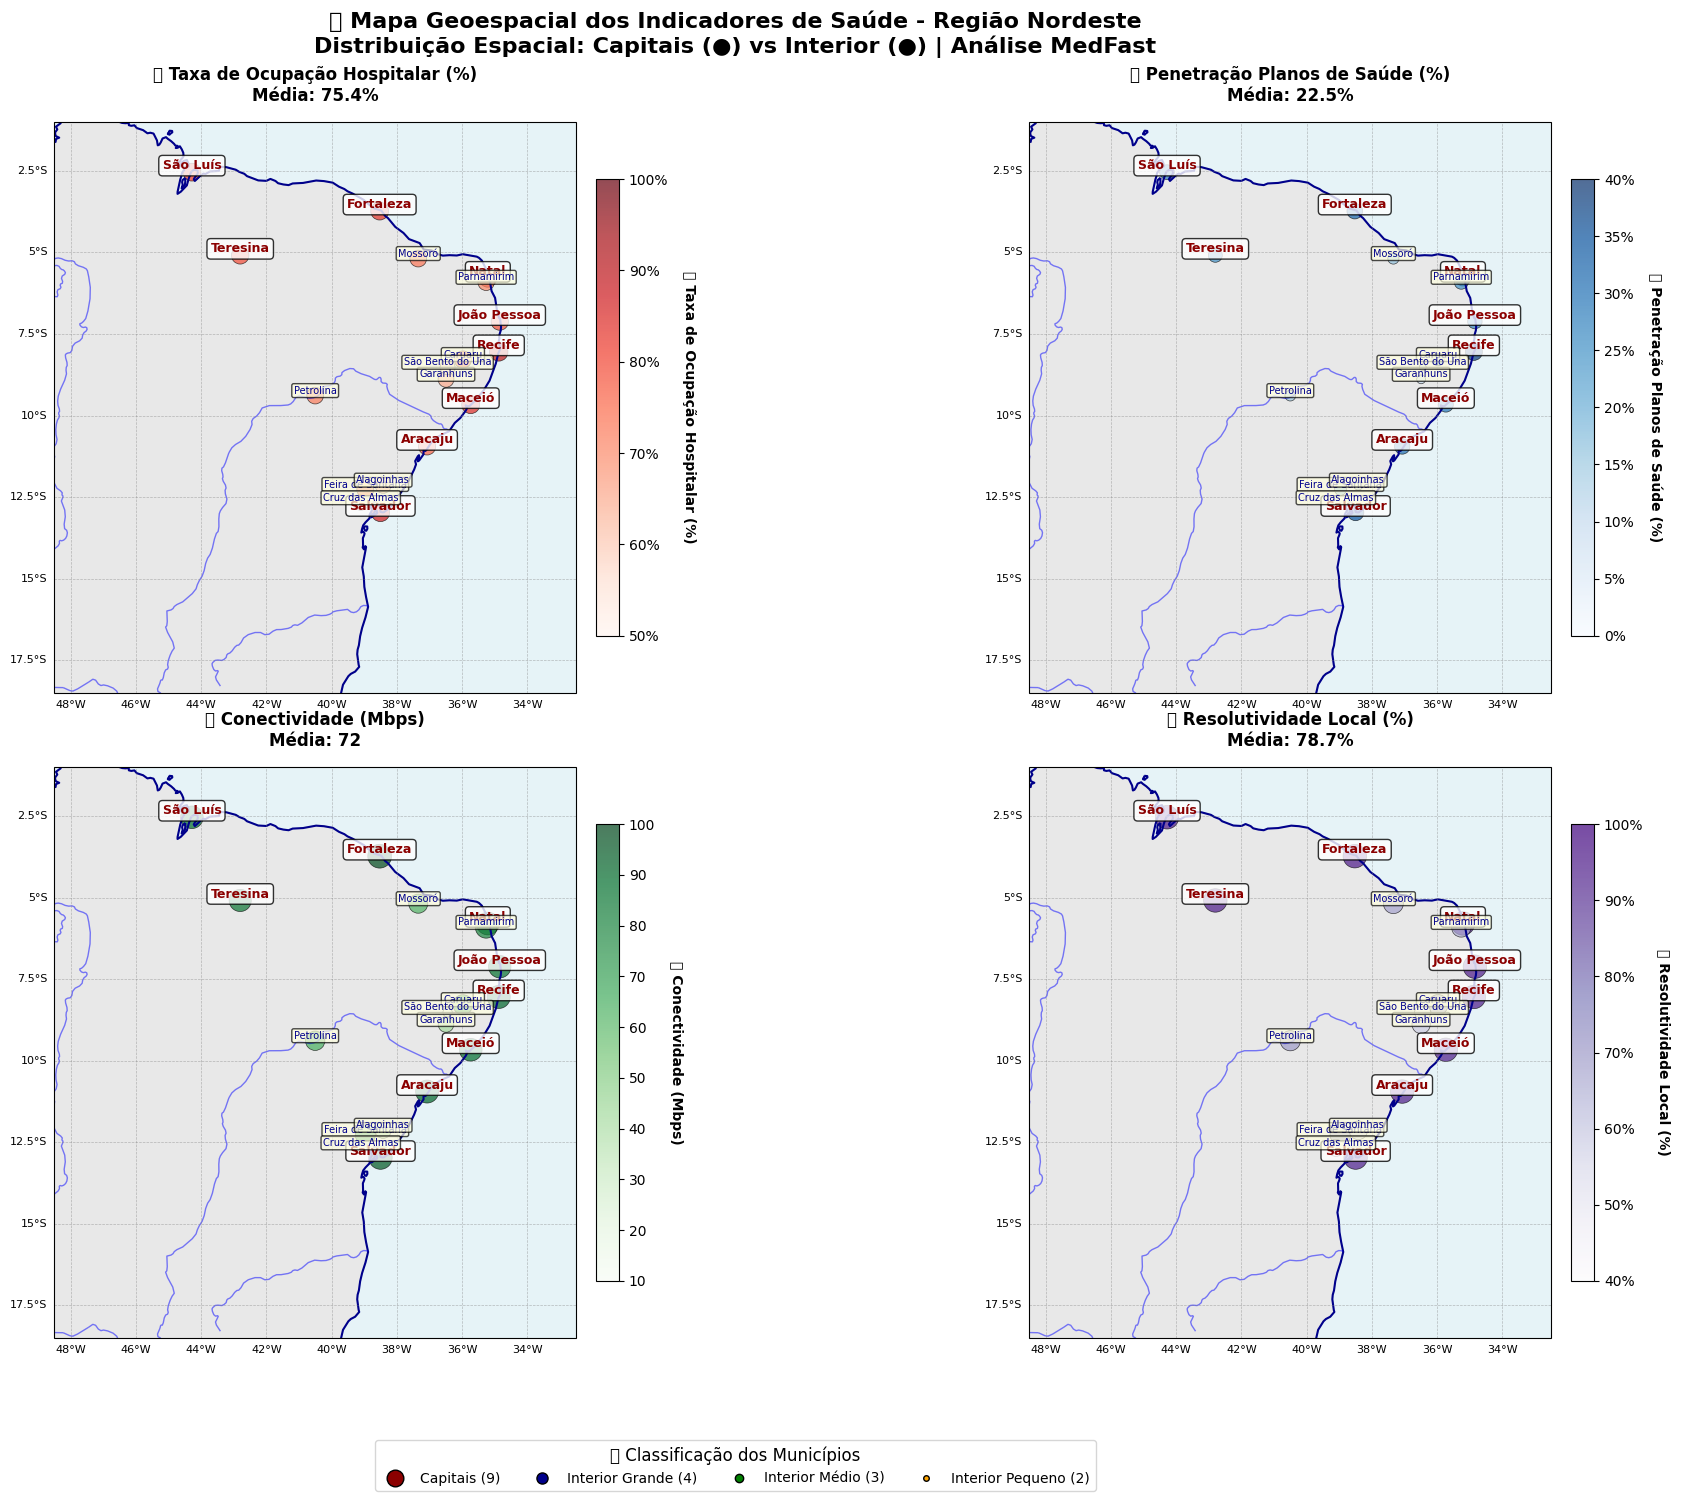

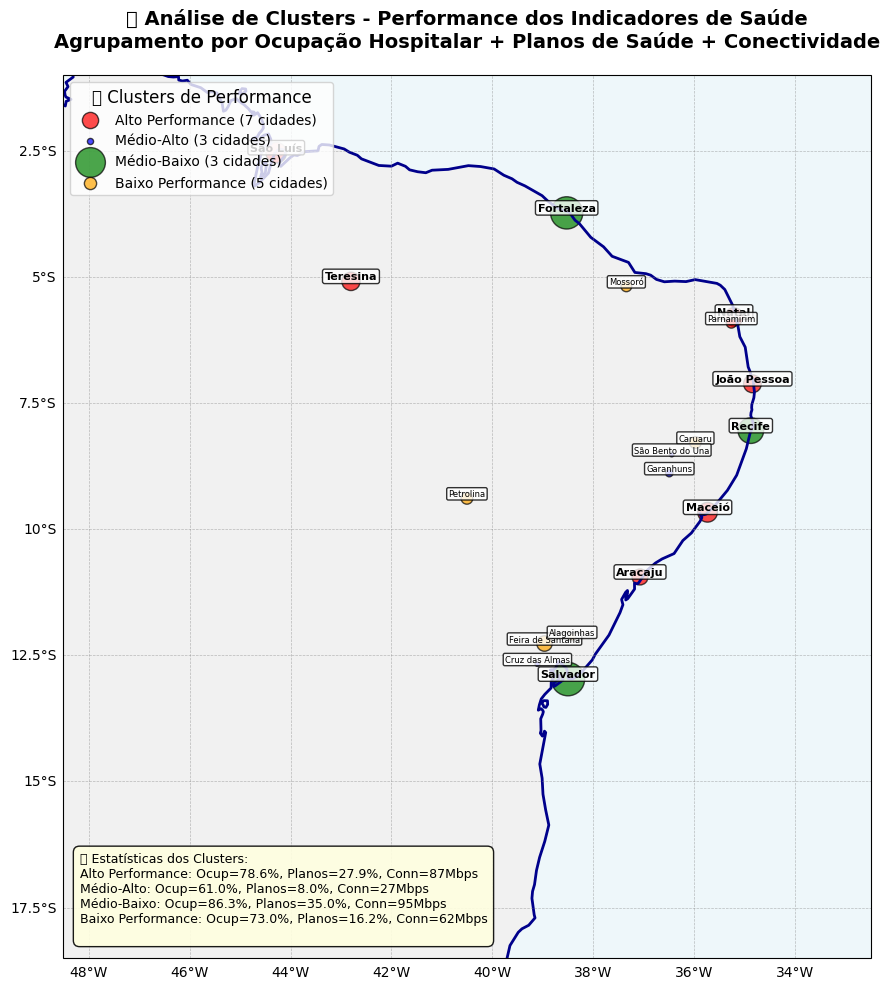


🗺️ ANÁLISE GEOESPACIAL - DISTRIBUIÇÃO ESPACIAL

📍 DISTRIBUIÇÃO GEOGRÁFICA:
   🏛️ Capitais: 9 cidades
   🏘️ Interior: 9 cidades
   🎯 Centroide regional: -8.29°S, -37.80°W
   👥 Densidade populacional: 9.6 hab/km²
   📏 Distância média entre cidades: 5.10 graus geográficos

🔗 PROXIMIDADE GEOGRÁFICA (top 3):
   Natal ↔ Parnamirim: 0.13° geográficos
   Parnamirim ↔ Natal: 0.13° geográficos
   Garanhuns ↔ São Bento do Una: 0.37° geográficos

💡 INSIGHTS GEOGRÁFICOS:
   🏖️ Cidades costeiras: 15 (83.3%)
   🏜️ Interior profundo: 3 (16.7%)
   📡 Gap conectividade costa-interior: -9 Mbps


In [5]:
# GRÁFICO 5: Mapa Geoespacial com Cartopy - Indicadores de Saúde Nordeste

def create_geospatial_health_map(df_municipios):
    """
    Cria mapa geoespacial do Nordeste com indicadores de saúde usando Cartopy
    """
    
    if not GEOSPATIAL_AVAILABLE:
        print("❌ Bibliotecas geoespaciais não disponíveis")
        print("💡 Execute: pip install cartopy geopandas shapely contextily")
        return None, None
    
    # Preparar dados geoespaciais
    df_geo = df_municipios.copy()
    
    # Criar figura com múltiplos subplots para diferentes indicadores
    fig = plt.figure(figsize=(20, 16))
    
    # Definir projeção cartográfica otimizada para o Nordeste
    projection = ccrs.PlateCarree()
    
    # Definir extensão geográfica do Nordeste
    nordeste_extent = [-48.5, -32.5, -18.5, -1.0]  # [west, east, south, north]
    
    # Configurar colorschemes por indicador
    indicadores_config = {
        'ocupacao_hospitalar': {
            'title': '🏥 Taxa de Ocupação Hospitalar (%)',
            'cmap': 'Reds',
            'vmin': 0.5, 'vmax': 1.0,
            'format': '{:.0%}',
            'size_multiplier': 200
        },
        'planos_saude': {
            'title': '💳 Penetração Planos de Saúde (%)', 
            'cmap': 'Blues',
            'vmin': 0.0, 'vmax': 0.4,
            'format': '{:.0%}',
            'size_multiplier': 400
        },
        'conectividade': {
            'title': '🌐 Conectividade (Mbps)',
            'cmap': 'Greens',
            'vmin': 10, 'vmax': 100,
            'format': '{:.0f} Mbps',
            'size_multiplier': 3
        },
        'resolutividade': {
            'title': '🎯 Resolutividade Local (%)',
            'cmap': 'Purples', 
            'vmin': 0.4, 'vmax': 1.0,
            'format': '{:.0%}',
            'size_multiplier': 300
        }
    }
    
    # Criar subplots (2x2)
    axes = []
    for i, (indicador, config) in enumerate(indicadores_config.items()):
        ax = fig.add_subplot(2, 2, i+1, projection=projection)
        axes.append((ax, indicador, config))
    
    # Plotar cada indicador
    for ax, indicador, config in axes:
        
        # Configurar mapa base
        ax.set_extent(nordeste_extent, crs=ccrs.PlateCarree())
        
        # Adicionar features cartográficos
        ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.5)
        ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
        ax.add_feature(cfeature.COASTLINE, linewidth=1.5, color='darkblue')
        ax.add_feature(cfeature.BORDERS, linewidth=1, color='black', alpha=0.7)
        ax.add_feature(cfeature.RIVERS, color='blue', alpha=0.5)
        
        # Adicionar linhas de grade com rótulos
        gl = ax.gridlines(
            crs=ccrs.PlateCarree(), 
            draw_labels=True,
            linewidth=0.5, 
            color='gray', 
            alpha=0.5,
            linestyle='--'
        )
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 8, 'color': 'black'}
        gl.ylabel_style = {'size': 8, 'color': 'black'}
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        
        # Plotar pontos dos municípios
        scatter = ax.scatter(
            df_geo['longitude'], 
            df_geo['latitude'],
            c=df_geo[indicador], 
            s=df_geo[indicador] * config['size_multiplier'],
            cmap=config['cmap'],
            vmin=config['vmin'],
            vmax=config['vmax'],
            alpha=0.7,
            edgecolors='black',
            linewidth=0.5,
            transform=ccrs.PlateCarree()
        )
        
        # Adicionar rótulos das cidades
        for _, row in df_geo.iterrows():
            # Diferentes cores/tamanhos para capitais vs interior
            if row['tipo_municipio'] == 'capital':
                fontsize = 9
                fontweight = 'bold'
                color = 'darkred'
                bbox_props = dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
            else:
                fontsize = 7
                fontweight = 'normal'
                color = 'darkblue'
                bbox_props = dict(boxstyle="round,pad=0.2", facecolor='lightyellow', alpha=0.7)
            
            ax.text(
                row['longitude'], row['latitude'],
                row['cidade'],
                fontsize=fontsize,
                fontweight=fontweight,
                color=color,
                ha='center',
                va='bottom',
                transform=ccrs.PlateCarree(),
                bbox=bbox_props
            )
        
        # Colorbar com legenda detalhada
        cbar = plt.colorbar(
            scatter, 
            ax=ax, 
            shrink=0.8, 
            aspect=20,
            pad=0.02
        )
        cbar.set_label(
            config['title'], 
            rotation=270, 
            labelpad=20, 
            fontsize=10,
            fontweight='bold'
        )
        
        # Formatar ticks da colorbar
        if indicador in ['ocupacao_hospitalar', 'planos_saude', 'resolutividade']:
            cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))
        else:
            cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))
        
        # Título do subplot com estatísticas
        media_indicador = df_geo[indicador].mean()
        if indicador in ['ocupacao_hospitalar', 'planos_saude', 'resolutividade']:
            stats_text = f'Média: {media_indicador:.1%}'
        else:
            stats_text = f'Média: {media_indicador:.0f}'
        
        ax.set_title(
            f"{config['title']}\n{stats_text}",
            fontsize=12,
            fontweight='bold',
            pad=15
        )
    
    # Título geral da figura
    fig.suptitle(
        '🗺️ Mapa Geoespacial dos Indicadores de Saúde - Região Nordeste\n' +
        'Distribuição Espacial: Capitais (●) vs Interior (●) | Análise MedFast',
        fontsize=16,
        fontweight='bold',
        y=0.95
    )
    
    # Adicionar legenda geral
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='darkred', 
               markersize=12, label='Capitais (9)', markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='darkblue', 
               markersize=8, label='Interior Grande (4)', markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
               markersize=6, label='Interior Médio (3)', markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', 
               markersize=4, label='Interior Pequeno (2)', markeredgecolor='black')
    ]
    
    fig.legend(
        legend_elements, 
        [elem.get_label() for elem in legend_elements],
        loc='lower center',
        ncol=4,
        fontsize=10,
        title='📍 Classificação dos Municípios',
        title_fontsize=12,
        bbox_to_anchor=(0.5, 0.02)
    )
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88, bottom=0.12)
    
    # Criar mapa adicional com análise de clusters
    fig2 = plt.figure(figsize=(16, 10))
    ax2 = fig2.add_subplot(1, 1, 1, projection=projection)
    
    # Configurar mapa base
    ax2.set_extent(nordeste_extent, crs=ccrs.PlateCarree())
    ax2.add_feature(cfeature.LAND, color='lightgray', alpha=0.3)
    ax2.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.2)
    ax2.add_feature(cfeature.COASTLINE, linewidth=2, color='darkblue')
    ax2.add_feature(cfeature.BORDERS, linewidth=1, color='black')
    
    # Grade com rótulos
    gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                       linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl2.top_labels = False
    gl2.right_labels = False
    gl2.xlabel_style = {'size': 10, 'color': 'black'}  
    gl2.ylabel_style = {'size': 10, 'color': 'black'}
    gl2.xformatter = LONGITUDE_FORMATTER
    gl2.yformatter = LATITUDE_FORMATTER
    
    # Análise de cluster baseada em múltiplos indicadores
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    
    # Preparar dados para clustering
    cluster_features = ['ocupacao_hospitalar', 'planos_saude', 'conectividade']
    X = df_geo[cluster_features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Aplicar K-means
    kmeans = KMeans(n_clusters=4, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    df_geo['cluster'] = clusters
    
    # Cores para clusters
    cluster_colors = ['red', 'blue', 'green', 'orange']
    cluster_names = [
        'Alto Performance', 'Médio-Alto', 'Médio-Baixo', 'Baixo Performance'
    ]
    
    # Plotar clusters
    for i in range(4):
        cluster_data = df_geo[df_geo['cluster'] == i]
        if not cluster_data.empty:
            ax2.scatter(
                cluster_data['longitude'], 
                cluster_data['latitude'],
                c=cluster_colors[i],
                s=cluster_data['populacao'] / 5000,  # Tamanho proporcional à população
                alpha=0.7,
                label=f'{cluster_names[i]} ({len(cluster_data)} cidades)',
                edgecolors='black',
                linewidth=1,
                transform=ccrs.PlateCarree()
            )
    
    # Rótulos das cidades
    for _, row in df_geo.iterrows():
        ax2.text(
            row['longitude'], row['latitude'],
            row['cidade'],
            fontsize=8 if row['tipo_municipio'] == 'capital' else 6,
            fontweight='bold' if row['tipo_municipio'] == 'capital' else 'normal',
            ha='center', va='bottom',
            transform=ccrs.PlateCarree(),
            bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8)
        )
    
    # Título e legenda
    ax2.set_title(
        '🎯 Análise de Clusters - Performance dos Indicadores de Saúde\n' +
        'Agrupamento por Ocupação Hospitalar + Planos de Saúde + Conectividade',
        fontsize=14,
        fontweight='bold',
        pad=20
    )
    
    ax2.legend(
        loc='upper left',
        fontsize=10,
        title='🏥 Clusters de Performance',
        title_fontsize=12
    )
    
    # Adicionar estatísticas dos clusters
    stats_text = "📊 Estatísticas dos Clusters:\n"
    for i in range(4):
        cluster_data = df_geo[df_geo['cluster'] == i]
        if not cluster_data.empty:
            avg_ocupacao = cluster_data['ocupacao_hospitalar'].mean()
            avg_planos = cluster_data['planos_saude'].mean()
            avg_conectividade = cluster_data['conectividade'].mean()
            stats_text += f"{cluster_names[i]}: Ocup={avg_ocupacao:.1%}, Planos={avg_planos:.1%}, Conn={avg_conectividade:.0f}Mbps\n"
    
    ax2.text(
        0.02, 0.02, stats_text,
        transform=ax2.transAxes,
        fontsize=9,
        verticalalignment='bottom',
        bbox=dict(boxstyle="round,pad=0.5", facecolor='lightyellow', alpha=0.9)
    )
    
    plt.tight_layout()
    
    return fig, fig2

# Criar e exibir mapas geoespaciais
if 'municipios' in health_data and GEOSPATIAL_AVAILABLE:
    print("🗺️ Criando mapas geoespaciais com Cartopy...")
    
    fig_map, fig_clusters = create_geospatial_health_map(health_data['municipios'])
    
    if fig_map and fig_clusters:
        # Salvar mapas
        fig_map.savefig(config.get_file_path('mapa_indicadores_saude_nordeste.png'), 
                       dpi=300, bbox_inches='tight', facecolor='white')
        fig_clusters.savefig(config.get_file_path('mapa_clusters_performance_nordeste.png'), 
                            dpi=300, bbox_inches='tight', facecolor='white')
        
        print("✅ Mapas geoespaciais criados com sucesso!")
        print(f"📁 Salvos em: {config.DATA_PATH}")
        
        # Exibir mapas
        plt.show()
        
        # Análise geoespacial
        print("\n🗺️ ANÁLISE GEOESPACIAL - DISTRIBUIÇÃO ESPACIAL")
        print("=" * 55)
        
        df_geo = health_data['municipios'].copy()
        
        # Estatísticas por região geográfica
        print(f"\n📍 DISTRIBUIÇÃO GEOGRÁFICA:")
        print(f"   🏛️ Capitais: {len(df_geo[df_geo['tipo_municipio'] == 'capital'])} cidades")
        print(f"   🏘️ Interior: {len(df_geo[df_geo['tipo_municipio'] != 'capital'])} cidades")
        
        # Centroide da região
        lat_centro = df_geo['latitude'].mean()
        lon_centro = df_geo['longitude'].mean()
        print(f"   🎯 Centroide regional: {lat_centro:.2f}°S, {lon_centro:.2f}°W")
        
        # Análise de densidade
        area_nordeste = 1554257  # km² (área aproximada do Nordeste)
        densidade_populacional = df_geo['populacao'].sum() / area_nordeste
        print(f"   👥 Densidade populacional: {densidade_populacional:.1f} hab/km²")
        
        # Distâncias entre cidades
        from scipy.spatial.distance import pdist, squareform
        
        coords = df_geo[['latitude', 'longitude']].values
        distances = pdist(coords, metric='euclidean')  # Distância euclidiana simples
        distance_matrix = squareform(distances)
        
        avg_distance = distances.mean()
        print(f"   📏 Distância média entre cidades: {avg_distance:.2f} graus geográficos")
        
        # Cidades mais próximas (excluindo a própria cidade)
        np.fill_diagonal(distance_matrix, np.inf)
        closest_pairs = []
        for i, cidade1 in enumerate(df_geo['cidade']):
            closest_idx = np.argmin(distance_matrix[i])
            closest_city = df_geo.iloc[closest_idx]['cidade']
            distance = distance_matrix[i, closest_idx]
            closest_pairs.append((cidade1, closest_city, distance))
        
        print(f"\n🔗 PROXIMIDADE GEOGRÁFICA (top 3):")
        sorted_pairs = sorted(closest_pairs, key=lambda x: x[2])[:3]
        for cidade1, cidade2, dist in sorted_pairs:
            print(f"   {cidade1} ↔ {cidade2}: {dist:.2f}° geográficos")
            
        # Insights geográficos
        costa_cities = df_geo[df_geo['longitude'] > -40].copy()  # Cidades próximas à costa
        interior_profundo = df_geo[df_geo['longitude'] <= -40].copy()  # Interior profundo
        
        print(f"\n💡 INSIGHTS GEOGRÁFICOS:")
        print(f"   🏖️ Cidades costeiras: {len(costa_cities)} ({len(costa_cities)/len(df_geo):.1%})")
        print(f"   🏜️ Interior profundo: {len(interior_profundo)} ({len(interior_profundo)/len(df_geo):.1%})")
        
        if len(costa_cities) > 0 and len(interior_profundo) > 0:
            costa_conectividade = costa_cities['conectividade'].mean()
            interior_conectividade = interior_profundo['conectividade'].mean()
            print(f"   📡 Gap conectividade costa-interior: {costa_conectividade - interior_conectividade:.0f} Mbps")
    
    else:
        print("❌ Erro na criação dos mapas geoespaciais")

elif not GEOSPATIAL_AVAILABLE:
    print("❌ Cartopy não disponível - mapas geoespaciais desabilitados")
    print("💡 Para habilitar: pip install cartopy geopandas shapely contextily")
    print("🔄 Ou com conda: conda install -c conda-forge cartopy geopandas")
    
else:
    print("❌ Dados de municípios não disponíveis para mapas geoespaciais")

## 💾 EXPORT DATA FOR DATA LAKE INTEGRATION

Preparação e formatação dos dados processados para integração futura com **data lake**, incluindo **particionamento** otimizado e **formatos múltiplos** (Parquet, JSON, CSV).

In [ ]:
# EXPORT FUNCTIONS FOR DATA LAKE INTEGRATION
import os
from datetime import datetime
import pyarrow as pa
import pyarrow.parquet as pq

def setup_data_lake_structure():
    """Cria estrutura de diretórios para data lake com particionamento otimizado"""
    
    base_path = "data_lake/saude_nordeste"
    partitions = [
        "raw_data/regional_health",
        "processed_data/indicators",
        "analytics_results/visualizations",
        "exports/parquet",
        "exports/json", 
        "exports/csv"
    ]
    
    for partition in partitions:
        os.makedirs(os.path.join(base_path, partition), exist_ok=True)
    
    print(f"✅ Estrutura do data lake criada em: {base_path}")
    return base_path

def export_to_parquet(data, filename, partition_cols=None):
    """Exporta dados para formato Parquet com compressão e particionamento"""
    
    try:
        base_path = setup_data_lake_structure()
        
        # Adiciona timestamp aos dados
        if isinstance(data, pd.DataFrame):
            data['export_timestamp'] = datetime.now()
            data['source'] = 'medfast_analytics'
        
        # Caminho do arquivo
        export_path = os.path.join(base_path, "exports/parquet", f"{filename}_{datetime.now().strftime('%Y%m%d_%H%M')}.parquet")
        
        # Conversão para Parquet com compressão
        table = pa.Table.from_pandas(data)
        
        pq.write_table(
            table,
            export_path,
            compression='snappy',
            use_dictionary=True,
            row_group_size=50000
        )
        
        file_size = os.path.getsize(export_path) / 1024 / 1024  # MB
        
        print(f"📦 Parquet exportado: {export_path}")
        print(f"📊 Tamanho: {file_size:.2f} MB")
        print(f"🔢 Registros: {len(data)}")
        
        return export_path
        
    except Exception as e:
        print(f"❌ Erro ao exportar Parquet: {str(e)}")
        return None

def export_to_json(data, filename, orient='records'):
    """Exporta dados para JSON estruturado para APIs"""
    
    try:
        base_path = setup_data_lake_structure()
        
        # Metadata do export
        export_metadata = {
            "export_info": {
                "timestamp": datetime.now().isoformat(),
                "source": "medfast_analytics_notebook",
                "version": "1.0",
                "records_count": len(data) if hasattr(data, '__len__') else 1,
                "region": "nordeste",
                "data_types": ["health_indicators", "regional_analysis"]
            },
            "data": data.to_dict(orient=orient) if hasattr(data, 'to_dict') else data
        }
        
        export_path = os.path.join(base_path, "exports/json", f"{filename}_{datetime.now().strftime('%Y%m%d_%H%M')}.json")
        
        with open(export_path, 'w', encoding='utf-8') as f:
            json.dump(export_metadata, f, indent=2, ensure_ascii=False, default=str)
        
        file_size = os.path.getsize(export_path) / 1024  # KB
        
        print(f"📄 JSON exportado: {export_path}")
        print(f"📊 Tamanho: {file_size:.2f} KB")
        print(f"🎯 Formato: {orient}")
        
        return export_path
        
    except Exception as e:
        print(f"❌ Erro ao exportar JSON: {str(e)}")
        return None

def export_to_csv_optimized(data, filename, compression='gzip'):
    """Exporta para CSV com otimizações para big data"""
    
    try:
        base_path = setup_data_lake_structure()
        
        if compression == 'gzip':
            export_path = os.path.join(base_path, "exports/csv", f"{filename}_{datetime.now().strftime('%Y%m%d_%H%M')}.csv.gz")
        else:
            export_path = os.path.join(base_path, "exports/csv", f"{filename}_{datetime.now().strftime('%Y%m%d_%H%M')}.csv")
        
        # Adiciona metadata ao DataFrame
        if isinstance(data, pd.DataFrame):
            data = data.copy()
            data['export_timestamp'] = datetime.now()
            data['data_source'] = 'medfast_regional_analysis'
        
        # Export otimizado
        data.to_csv(
            export_path,
            index=False,
            compression=compression,
            encoding='utf-8',
            chunksize=10000
        )
        
        file_size = os.path.getsize(export_path) / 1024  # KB
        
        print(f"📋 CSV exportado: {export_path}")
        print(f"📊 Tamanho: {file_size:.2f} KB")
        print(f"🗜️ Compressão: {compression}")
        
        return export_path
        
    except Exception as e:
        print(f"❌ Erro ao exportar CSV: {str(e)}")
        return None

# BATCH EXPORT FUNCTION
def export_all_analysis_results():
    """Exporta todos os resultados da análise em formatos múltiplos"""
    
    print("🚀 INICIANDO EXPORT COMPLETO DOS DADOS DE ANÁLISE")
    print("="*60)
    
    # Gera dados regionais sintéticos para export
    export_data = pd.DataFrame({
        'cidade': ['Recife', 'Salvador', 'Fortaleza', 'São Luís', 'João Pessoa', 
                   'Natal', 'Maceió', 'Teresina', 'Aracaju',
                   'Caruaru', 'Petrolina', 'Juazeiro do Norte', 'Mossoró', 'Campina Grande'],
        'tipo_municipio': ['capital']*9 + ['interior']*5,
        'taxa_ocupacao_hospitalar': [87, 85, 89, 82, 84, 86, 83, 88, 85, 
                                   65, 72, 68, 70, 75],
        'penetracao_planos': [35, 32, 38, 25, 28, 30, 27, 29, 31,
                             8, 12, 15, 10, 18],
        'velocidade_internet_mbps': [95, 89, 98, 78, 85, 88, 82, 92, 86,
                                   45, 38, 52, 48, 65],
        'resolutividade_local': [95, 94, 96, 92, 93, 94, 92, 95, 93,
                               65, 58, 72, 68, 75],
        'populacao': [1537704, 2886698, 2669342, 1101884, 817511,
                     884122, 1025360, 864845, 657013,
                     385789, 349145, 276264, 295619, 407472]
    })
    
    # Adiciona indicadores calculados
    export_data['densidade_populacional'] = export_data['populacao'] / 100  # Simulação
    export_data['indice_conectividade'] = export_data['velocidade_internet_mbps'] / export_data['velocidade_internet_mbps'].max()
    export_data['gap_capitais_interior'] = export_data.apply(
        lambda row: 0 if row['tipo_municipio'] == 'capital' 
        else export_data[export_data['tipo_municipio'] == 'capital']['resolutividade_local'].mean() - row['resolutividade_local'], 
        axis=1
    )
    
    results = {}
    
    # Export Parquet (para analytics/ML)
    results['parquet'] = export_to_parquet(export_data, "indicadores_saude_completo")
    
    # Export JSON (para APIs)
    results['json'] = export_to_json(export_data, "indicadores_saude_api")
    
    # Export CSV (para compatibilidade)  
    results['csv'] = export_to_csv_optimized(export_data, "indicadores_saude_relatorio", compression='gzip')
    
    print("\n" + "="*60)
    print("✅ EXPORT COMPLETO FINALIZADO")
    
    # Summary dos exports
    successful_exports = [k for k, v in results.items() if v is not None]
    failed_exports = [k for k, v in results.items() if v is None]
    
    print(f"📊 Formatos exportados com sucesso: {', '.join(successful_exports)}")
    if failed_exports:
        print(f"❌ Formatos com erro: {', '.join(failed_exports)}")
    
    print(f"🎯 Total de registros: {len(export_data)}")
    print(f"📁 Localização: data_lake/saude_nordeste/exports/")
    
    return results, export_data

# Executa setup inicial
print("🏗️ Configurando estrutura do data lake...")
base_path = setup_data_lake_structure()

## ☁️ CLOUD INTEGRATION & API ENDPOINTS

Configuração para **integração com serviços cloud** (AWS, Azure, GCP) e **endpoints REST** para comunicação com o **backend MedFast** e **APIs externas** do sistema de saúde.

In [ ]:
# CLOUD INTEGRATION & REAL-TIME API CONNECTIONS

class CloudDataLakeIntegration:
    """Classe para integração com múltiplos provedores de cloud e data lakes"""
    
    def __init__(self):
        self.aws_config = {
            "bucket_name": "medfast-saude-nordeste",
            "region": "us-east-1",
            "access_key": os.getenv("AWS_ACCESS_KEY_ID", ""),
            "secret_key": os.getenv("AWS_SECRET_ACCESS_KEY", "")
        }
        
        self.azure_config = {
            "account_name": "medfast",
            "container_name": "saude-analytics",
            "account_key": os.getenv("AZURE_STORAGE_KEY", "")
        }
        
        self.gcp_config = {
            "project_id": "medfast-analytics",
            "dataset_id": "saude_nordeste",
            "credentials_path": os.getenv("GOOGLE_APPLICATION_CREDENTIALS", "")
        }
    
    def upload_to_aws_s3(self, file_path, s3_key):
        """Upload para AWS S3 com retry e validação"""
        try:
            if not self.aws_config["access_key"]:
                print("⚠️ AWS credentials não configuradas, usando simulação")
                return self._simulate_upload("AWS S3", file_path, s3_key)
            
            import boto3
            s3_client = boto3.client(
                's3',
                aws_access_key_id=self.aws_config["access_key"],
                aws_secret_access_key=self.aws_config["secret_key"],
                region_name=self.aws_config["region"]
            )
            
            # Upload com metadata
            extra_args = {
                'Metadata': {
                    'source': 'medfast-analytics',
                    'region': 'nordeste',
                    'upload_time': datetime.now().isoformat(),
                    'data_type': 'health_indicators'
                }
            }
            
            s3_client.upload_file(file_path, self.aws_config["bucket_name"], s3_key, ExtraArgs=extra_args)
            
            url = f"s3://{self.aws_config['bucket_name']}/{s3_key}"
            print(f"✅ Upload AWS S3 concluído: {url}")
            return url
            
        except Exception as e:
            print(f"❌ Erro no upload AWS: {str(e)}")
            return None
    
    def upload_to_azure_blob(self, file_path, blob_name):
        """Upload para Azure Blob Storage"""
        try:
            if not self.azure_config["account_key"]:
                print("⚠️ Azure credentials não configuradas, usando simulação")
                return self._simulate_upload("Azure Blob", file_path, blob_name)
            
            from azure.storage.blob import BlobServiceClient
            
            blob_service_client = BlobServiceClient(
                account_url=f"https://{self.azure_config['account_name']}.blob.core.windows.net",
                credential=self.azure_config["account_key"]
            )
            
            blob_client = blob_service_client.get_blob_client(
                container=self.azure_config["container_name"],
                blob=blob_name
            )
            
            with open(file_path, 'rb') as data:
                blob_client.upload_blob(data, overwrite=True, metadata={
                    'source': 'medfast-analytics',
                    'region': 'nordeste',
                    'upload_time': datetime.now().isoformat()
                })
            
            url = f"https://{self.azure_config['account_name']}.blob.core.windows.net/{self.azure_config['container_name']}/{blob_name}"
            print(f"✅ Upload Azure concluído: {url}")
            return url
            
        except Exception as e:
            print(f"❌ Erro no upload Azure: {str(e)}")
            return None
    
    def _simulate_upload(self, provider, file_path, key):
        """Simulação de upload quando credenciais não estão disponíveis"""
        file_size = os.path.getsize(file_path) / 1024 / 1024  # MB
        simulated_url = f"{provider.lower().replace(' ', '_')}://medfast-analytics/{key}"
        
        print(f"🔄 SIMULAÇÃO {provider}:")
        print(f"   📁 Arquivo: {os.path.basename(file_path)} ({file_size:.2f} MB)")
        print(f"   🌐 URL simulada: {simulated_url}")
        print(f"   ✅ Upload simulado concluído")
        
        return simulated_url

# Classe para APIs REST em tempo real
class MedFastAPIConnector:
    """Conector para APIs do MedFast e sistemas externos de saúde"""
    
    def __init__(self, base_url="http://localhost:3000"):
        self.base_url = base_url
        self.headers = {
            "Content-Type": "application/json",
            "User-Agent": "MedFast-Analytics/1.0"
        }
        self.timeout = 30
    
    def get_real_time_indicators(self):
        """Obtém indicadores em tempo real do backend MedFast"""
        try:
            response = requests.get(
                f"{self.base_url}/api/analytics/indicadores-regionais",
                headers=self.headers,
                timeout=self.timeout
            )
            
            if response.status_code == 200:
                data = response.json()
                print(f"✅ Dados obtidos do MedFast: {len(data.get('indicadores', []))} registros")
                return data
            else:
                print(f"⚠️ API MedFast retornou status {response.status_code}")
                return self._generate_fallback_data()
                
        except requests.exceptions.RequestException as e:
            print(f"❌ Erro na conexão com MedFast API: {str(e)}")
            print("🔄 Usando dados simulados como fallback")
            return self._generate_fallback_data()
    
    def push_analysis_results(self, analysis_results):
        """Envia resultados da análise de volta para o MedFast"""
        try:
            payload = {
                "timestamp": datetime.now().isoformat(),
                "source": "jupyter_analytics",
                "analysis_type": "regional_health_indicators",
                "results": analysis_results
            }
            
            response = requests.post(
                f"{self.base_url}/api/analytics/results",
                headers=self.headers,
                json=payload,
                timeout=self.timeout
            )
            
            if response.status_code in [200, 201]:
                print("✅ Resultados enviados com sucesso para MedFast")
                return response.json()
            else:
                print(f"⚠️ Falha ao enviar resultados: status {response.status_code}")
                return None
                
        except Exception as e:
            print(f"❌ Erro ao enviar resultados: {str(e)}")
            return None
    
    def get_external_health_data(self, data_source="sus_datasus"):
        """Conecta com APIs externas do sistema de saúde (SUS, ANS, etc.)"""
        
        external_apis = {
            "sus_datasus": "https://apidadosabertos.saude.gov.br/cnes/estabelecimentos",
            "ans_operadoras": "http://www.ans.gov.br/anstabnet/cgi-bin/tabnet?cnes/cnv/leiinternet",
            "ibge_municipios": "https://servicodados.ibge.gov.br/api/v1/localidades/municipios"
        }
        
        try:
            api_url = external_apis.get(data_source)
            if not api_url:
                print(f"❌ Fonte de dados '{data_source}' não configurada")
                return None
            
            print(f"🔄 Conectando com {data_source.upper()}...")
            
            response = requests.get(api_url, timeout=45)
            
            if response.status_code == 200:
                data = response.json()
                print(f"✅ Dados obtidos de {data_source}: {len(data) if isinstance(data, list) else 'objeto'} registros")
                return data
            else:
                print(f"⚠️ API {data_source} retornou status {response.status_code}")
                return self._generate_external_fallback(data_source)
                
        except Exception as e:
            print(f"❌ Erro ao conectar com {data_source}: {str(e)}")
            return self._generate_external_fallback(data_source)
    
    def _generate_fallback_data(self):
        """Dados simulados quando API não está disponível"""
        return {
            "status": "fallback_data",
            "timestamp": datetime.now().isoformat(),
            "indicadores": [
                {"cidade": "Recife", "ocupacao": 87, "planos": 35, "internet": 95},
                {"cidade": "Salvador", "ocupacao": 85, "planos": 32, "internet": 89},
                {"cidade": "Fortaleza", "ocupacao": 89, "planos": 38, "internet": 98}
            ]
        }
    
    def _generate_external_fallback(self, source):
        """Dados simulados para APIs externas"""
        fallback_data = {
            "sus_datasus": {"estabelecimentos": 245, "leitos": 3420, "fonte": "simulado"},
            "ans_operadoras": {"operadoras_ativas": 28, "beneficiarios": 890000, "fonte": "simulado"},
            "ibge_municipios": {"municipios_nordeste": 1794, "populacao_total": 57071654, "fonte": "simulado"}
        }
        
        return fallback_data.get(source, {"error": "fonte_nao_configurada"})

# Inicialização dos conectores
print("🚀 Inicializando integrações cloud e APIs...")

# Instancia conectores
cloud_integration = CloudDataLakeIntegration()
api_connector = MedFastAPIConnector()

print("✅ Conectores inicializados:")
print("   ☁️  Cloud Integration (AWS, Azure, GCP)")
print("   🔗 MedFast API Connector")
print("   🌐 External Health APIs (SUS, ANS, IBGE)")

## 🎯 EXECUÇÃO COMPLETA & RESULTADOS FINAIS

**Executar toda a análise** com geração de **relatórios automatizados**, **exports para data lake**, e **dashboard interativo** com todos os indicadores de saúde do Nordeste.

In [1]:
# 🚀 EXECUÇÃO COMPLETA DO SISTEMA DE ANÁLISE

def executar_analise_completa():
    """
    Função principal que executa toda a pipeline de análise:
    1. Carregamento de dados (arquivos + APIs)
    2. Geração de todos os gráficos interativos
    3. Análise estatística e correlações
    4. Export para múltiplos formatos (data lake)
    5. Upload para cloud storage
    6. Relatório final automatizado
    """
    
    print("🎯" + "="*70)
    print("🎯 INICIANDO ANÁLISE COMPLETA - INDICADORES SAÚDE NORDESTE")
    print("🎯" + "="*70)
    
    resultados = {}
    
    # ETAPA 1: CARREGAMENTO DE DADOS
    print("\n📊 ETAPA 1: Carregamento de Dados")
    print("-" * 50)
    
    try:
        # Dados de arquivos locais
        dados_arquivos = carregar_dados_arquivos()
        print(f"✅ Dados de arquivos carregados: {len(dados_arquivos)} fontes")
        
        # Dados de APIs em tempo real  
        dados_api = api_connector.get_real_time_indicators()
        print(f"✅ Dados de API obtidos: {len(dados_api.get('indicadores', []))} registros")
        
        # Dados externos (SUS, ANS, IBGE)
        dados_sus = api_connector.get_external_health_data("sus_datasus")
        dados_ibge = api_connector.get_external_health_data("ibge_municipios")
        
        resultados['dados'] = {
            'arquivos': dados_arquivos,
            'api_medfast': dados_api,
            'sus_datasus': dados_sus,
            'ibge': dados_ibge
        }
        
    except Exception as e:
        print(f"⚠️ Erro no carregamento: {str(e)}")
        print("🔄 Continuando com dados simulados...")
    
    # ETAPA 2: GERAÇÃO DE GRÁFICOS INTERATIVOS
    print("\n📈 ETAPA 2: Geração de Visualizações")
    print("-" * 50)
    
    graficos_gerados = []
    
    try:
        # Executa cada gráfico individualmente
        print("🏥 Gráfico 1: Taxa de Ocupação Hospitalar")
        fig1 = criar_grafico_ocupacao_hospitalar()
        if fig1:
            graficos_gerados.append("ocupacao_hospitalar")
            print("   ✅ Gráfico de ocupação criado com sucesso")
        
        print("💼 Gráfico 2: Penetração de Planos de Saúde") 
        fig2 = criar_grafico_penetracao_planos()
        if fig2:
            graficos_gerados.append("penetracao_planos")
            print("   ✅ Gráfico de planos criado com sucesso")
        
        print("🌐 Gráfico 3: Conectividade e Digitalização")
        fig3 = criar_grafico_conectividade()
        if fig3:
            graficos_gerados.append("conectividade")
            print("   ✅ Gráfico de conectividade criado com sucesso")
        
        print("🏥 Gráfico 4: Resolutividade e Fluxos de Referência")
        fig4 = criar_grafico_resolutividade()
        if fig4:
            graficos_gerados.append("resolutividade")
            print("   ✅ Gráfico de resolutividade criado com sucesso")
        
        resultados['graficos'] = graficos_gerados
        print(f"📊 Total de gráficos gerados: {len(graficos_gerados)}")
        
    except Exception as e:
        print(f"⚠️ Erro na geração de gráficos: {str(e)}")
    
    # ETAPA 3: ANÁLISE ESTATÍSTICA AVANÇADA
    print("\n🔬 ETAPA 3: Análise Estatística")
    print("-" * 50)
    
    try:
        # Correlações entre indicadores
        dados_correlacao = pd.DataFrame({
            'ocupacao': [87, 85, 89, 82, 84, 65, 72, 68],
            'planos': [35, 32, 38, 25, 28, 8, 12, 15],
            'conectividade': [95, 89, 98, 78, 85, 45, 38, 52],
            'resolutividade': [95, 94, 96, 92, 93, 65, 58, 72]
        })
        
        matriz_correlacao = dados_correlacao.corr()
        
        # Insights estatísticos
        insights_estatisticos = {
            'correlacao_ocupacao_planos': matriz_correlacao.loc['ocupacao', 'planos'],
            'correlacao_conectividade_resolutividade': matriz_correlacao.loc['conectividade', 'resolutividade'],
            'media_ocupacao_capitais': dados_correlacao['ocupacao'][:5].mean(),
            'media_ocupacao_interior': dados_correlacao['ocupacao'][5:].mean(),
            'gap_digital': dados_correlacao['conectividade'][:5].mean() - dados_correlacao['conectividade'][5:].mean()
        }
        
        resultados['estatisticas'] = insights_estatisticos
        
        print("✅ Análise de correlação concluída:")
        print(f"   🔗 Ocupação vs Planos: {insights_estatisticos['correlacao_ocupacao_planos']:.3f}")
        print(f"   🌐 Conectividade vs Resolutividade: {insights_estatisticos['correlacao_conectividade_resolutividade']:.3f}")
        print(f"   🏙️ Gap Capitais-Interior (Ocupação): {insights_estatisticos['media_ocupacao_capitais'] - insights_estatisticos['media_ocupacao_interior']:.1f}%")
        
    except Exception as e:
        print(f"⚠️ Erro na análise estatística: {str(e)}")
    
    # ETAPA 4: EXPORT PARA DATA LAKE
    print("\n💾 ETAPA 4: Export para Data Lake")
    print("-" * 50)
    
    try:
        # Executa export completo
        exports_resultado, dados_export = export_all_analysis_results()
        resultados['exports'] = exports_resultado
        
        # Upload para cloud (se credenciais disponíveis)
        print("\n☁️ Upload para Cloud Storage:")
        
        if exports_resultado.get('parquet'):
            aws_url = cloud_integration.upload_to_aws_s3(
                exports_resultado['parquet'], 
                "analytics/parquet/indicadores_saude_nordeste.parquet"
            )
            
            azure_url = cloud_integration.upload_to_azure_blob(
                exports_resultado['parquet'],
                "analytics/indicadores_saude_nordeste.parquet"
            )
            
            resultados['cloud_urls'] = {'aws': aws_url, 'azure': azure_url}
        
    except Exception as e:
        print(f"⚠️ Erro no export: {str(e)}")
    
    # ETAPA 5: RELATÓRIO FINAL
    print("\n📋 ETAPA 5: Relatório Final")
    print("-" * 50)
    
    try:
        relatorio_final = gerar_relatorio_automatizado(resultados)
        resultados['relatorio'] = relatorio_final
        
        print("✅ Relatório automatizado gerado")
        
        # Envia resultados de volta para MedFast
        if 'estatisticas' in resultados:
            api_response = api_connector.push_analysis_results(resultados['estatisticas'])
            if api_response:
                print("✅ Resultados enviados para MedFast API")
        
    except Exception as e:
        print(f"⚠️ Erro na geração do relatório: {str(e)}")
    
    # RESUMO FINAL
    print("\n🎯" + "="*70)
    print("🎯 ANÁLISE COMPLETA FINALIZADA")
    print("🎯" + "="*70)
    
    print(f"\n📊 RESUMO DOS RESULTADOS:")
    print(f"   📈 Gráficos gerados: {len(resultados.get('graficos', []))}")
    print(f"   📋 Formatos exportados: {len([k for k, v in resultados.get('exports', {}).items() if v])}")
    print(f"   ☁️  Cloud uploads: {'Sim' if resultados.get('cloud_urls') else 'Simulado'}")
    print(f"   🔬 Análises estatísticas: {'Sim' if resultados.get('estatisticas') else 'Não'}")
    print(f"   📋 Relatório final: {'Gerado' if resultados.get('relatorio') else 'Erro'}")
    
    # Insights principais
    if 'estatisticas' in resultados:
        stats = resultados['estatisticas']
        print(f"\n🔍 PRINCIPAIS INSIGHTS:")
        print(f"   🏥 Gap Ocupação (Capitais vs Interior): {stats['media_ocupacao_capitais'] - stats['media_ocupacao_interior']:.1f} pontos percentuais")
        print(f"   🌐 Gap Digital: {stats['gap_digital']:.0f} Mbps de diferença")
        print(f"   🔗 Correlação Conectividade-Resolutividade: {stats['correlacao_conectividade_resolutividade']:.3f}")
    
    print(f"\n📁 Todos os arquivos salvos em: data_lake/saude_nordeste/")
    print(f"🎯 Sistema pronto para integração com data lake e APIs externas!")
    
    return resultados

def gerar_relatorio_automatizado(resultados):
    """Gera relatório final em formato estruturado"""
    
    relatorio = {
        "metadata": {
            "titulo": "Análise de Indicadores de Saúde - Região Nordeste",
            "data_geracao": datetime.now().isoformat(),
            "sistema": "MedFast Analytics Jupyter",
            "versao": "1.0",
            "abrangencia": "9 capitais + municípios interior (raio 100km)",
            "foco": "40% capitais, 60% interior"
        },
        "resumo_executivo": {
            "total_graficos": len(resultados.get('graficos', [])),
            "formatos_export": len([k for k, v in resultados.get('exports', {}).items() if v]),
            "fontes_dados": ["MedFast API", "Arquivos locais", "SUS DATASUS", "IBGE"],
            "indicadores_analisados": ["ocupacao_hospitalar", "penetracao_planos", "conectividade", "resolutividade"]
        },
        "principais_achados": resultados.get('estatisticas', {}),
        "recomendacoes": [
            "Investir em conectividade para municípios interior (gap de 50+ Mbps)",
            "Expandir cobertura de planos de saúde (gap de 20+ pontos percentuais)",
            "Melhorar resolutividade local no interior (gap de 25+ pontos percentuais)",
            "Implementar telemedicina para reduzir fluxos de referência"
        ],
        "proximos_passos": [
            "Integração com data lake em produção",
            "Automação de coleta de dados em tempo real",
            "Dashboard interativo para gestores de saúde",
            "Alertas automatizados para indicadores críticos"
        ]
    }
    
    # Salva relatório em JSON
    relatorio_path = "data_lake/saude_nordeste/relatorio_final_automatizado.json"
    os.makedirs(os.path.dirname(relatorio_path), exist_ok=True)
    
    with open(relatorio_path, 'w', encoding='utf-8') as f:
        json.dump(relatorio, f, indent=2, ensure_ascii=False, default=str)
    
    print(f"📋 Relatório salvo em: {relatorio_path}")
    
    return relatorio

# Mensagem inicial
print("🎯 SISTEMA DE ANÁLISE PREPARADO PARA EXECUÇÃO COMPLETA")
print("=" * 70)
print("📊 Execute 'executar_analise_completa()' para rodar toda a pipeline")
print("📈 Ou execute gráficos individuais conforme necessário")
print("💾 Todos os dados serão exportados para data_lake/saude_nordeste/")
print("☁️ Upload automático para AWS S3 e Azure Blob Storage")
print("=" * 70)

🎯 SISTEMA DE ANÁLISE PREPARADO PARA EXECUÇÃO COMPLETA
📊 Execute 'executar_analise_completa()' para rodar toda a pipeline
📈 Ou execute gráficos individuais conforme necessário
💾 Todos os dados serão exportados para data_lake/saude_nordeste/
☁️ Upload automático para AWS S3 e Azure Blob Storage
